# Explaibability Agent

Explaibability Agent (Creates the explainable output of the recommendation)

## **1. Load And Preprocess Data**

This part's only purpose is to load the data used in the Explainability Agent. This process is described in detail in the Preparation Agent. 

**Note: When computing the script with another Household than Household 1 you might need to adapt some parameters**

### **1.1 Initialize And Load Python Scripts**

In [207]:
import pandas as pd
import numpy as np
import os
import sqlite3
dir = 'D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main'
os.chdir(dir)

from helper_functions import Helper
import agents 
import pandas as pd

helper = Helper()

dbfile  = "D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main/home-assistant_v2.db"


In [208]:
import warnings
warnings.filterwarnings("ignore")

In [209]:
#from agents import Evaluation_Agent
from helper_functions import Helper

helper = Helper()

import pandas as pd
import numpy as np
import json
import pickle
from copy import deepcopy
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
#import statsmodels.api as sm

import scipy.spatial

### **1.2 Set Parameters For Pre-processing Step**

In [210]:
DATA_PATH = 'data/'
EXPORT_PATH = 'export/'

In [211]:
# manual input, determined using information provided in the readme
# validated in the next step using the validate thresholds functionality
shiftable_devices = {
    1: ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]
}

In [212]:
# manual input, determined using information provided in the readme
# validated in the next step using the validate thresholds functionality
activity_devices = {
    1: deepcopy(shiftable_devices[1]) + ["light.olaf_der_gesundigte", "light.blub", "light.extended_color_light_1", "switch.shellyplug_s_80646f824e22", 
                    "light.bogenleuchte", "light.hue_color_candle_1", "light.hue_color_candle_2"]
}

In [213]:
thresholds = {
    1: 0.06
}

In [214]:
# validating the thresholds for household 1 to show noise in the data
household_id = 1

### **1.3 Pre-process Data For Input In Device_Usage Agent**

In [215]:
# creating the config including the user input
config =  {'data': {'household': deepcopy(household_id)}}
config['user_input'] = {
    'shiftable_devices': deepcopy(shiftable_devices[config['data']['household']]),
    'active_appliances': deepcopy(activity_devices[config['data']['household']]),
    'threshold': deepcopy(thresholds[config['data']['household']])
}

config

{'data': {'household': 1},
 'user_input': {'shiftable_devices': ['sensor.shellyplug_s_4022d88961b4_power',
   'sensor.shellyplug_s_4022d88984b8_power'],
  'active_appliances': ['sensor.shellyplug_s_4022d88961b4_power',
   'sensor.shellyplug_s_4022d88984b8_power',
   'light.olaf_der_gesundigte',
   'light.blub',
   'light.extended_color_light_1',
   'switch.shellyplug_s_80646f824e22',
   'light.bogenleuchte',
   'light.hue_color_candle_1',
   'light.hue_color_candle_2'],
  'threshold': 0.06}}

In [216]:
config['user_input']['active_appliances']

['sensor.shellyplug_s_4022d88961b4_power',
 'sensor.shellyplug_s_4022d88984b8_power',
 'light.olaf_der_gesundigte',
 'light.blub',
 'light.extended_color_light_1',
 'switch.shellyplug_s_80646f824e22',
 'light.bogenleuchte',
 'light.hue_color_candle_1',
 'light.hue_color_candle_2']

In [217]:
config['user_input']['shiftable_devices']

['sensor.shellyplug_s_4022d88961b4_power',
 'sensor.shellyplug_s_4022d88984b8_power']

In [218]:
model_type = 'random forest'

## **2.  Constructing the Evaluation Agent**

### **2.1 Initialize Agent**

First we define the **Evaluation Agent class**.

In [219]:
# Original Evaluation Agent
# ===============================================================================================
class Evaluation_Agent:
    def __init__(self, dbfile, model_type, config, training_days = 360, load_data=True, load_files=None, weather_sel=False, xai = False):
        import agents
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()

        self.model_type = model_type
        self.config = config
        self.weather_sel = weather_sel
        self.xai = xai
        if load_data:
            self.preparation = agents.Preparation_Agent(dbfile, config['user_input']['shiftable_devices'], config['user_input']['active_appliances'], training_days)
        else:
            self.preparation = agents.Preparation_Agent(None)

        self.price = (
            agents.Price_Agent()
            if load_data
            else None
        )
        self.friendly_names = self.preparation.pipeline_friendly_names(self.preparation.input)
        self.start = str(min(self.preparation.input.last_updated_ts))[0:10]
        self.end = str(max(self.preparation.input.last_updated_ts))[0:10]
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_" + device.replace(".", "_").replace("(", "").replace(")", "").lower())
            exec(f"self.{name} = None")
        self.activity = None
        self.load = None
        self.recommendation = None
        self.df = {}
        self.output = {}
        self.errors = {}
        self.agent_scores = {}
        self.agent_predictions_list_activity = {}
        self.agent_predictions_list_usage = {}
        self.cold_start_scores = {}
        self.results = {}
        self.cold_start_days = pd.DataFrame()
        if load_files != None:
            self.load_from_drive(load_files)


### 2.2 Loading Data


In [220]:
# helper: loading and storing intermediary results and further helper
# -------------------------------------------------------------------------------------------
def _load_object(self, filename):
    import pickle
    import json
    import yaml

    # using a command dict as a if-list
    commands = {
        "pkl": f"pickle.load(open('{filename}', 'rb'))",
        "json": f"json.load(open('{filename}', 'r'))",
        "yaml": f"yaml.load(open('{filename}', 'r'), Loader = yaml.Loader)",
    }

    *_, name, ftype = filename.split(".")
    name = name[name.rfind("_") + 1:]
    obj = eval(commands[ftype])
    self[name] = obj
    

# add to Evaluation agent
setattr(Evaluation_Agent, '_load_object', _load_object)
del _load_object 

### 2.3 Export Data

In [221]:
def load_from_drive(self, files):
    files = [files] if type(files) != list else files
    for filename in files:
        self._load_object(filename)
        
# add to Evaluation agent
setattr(Evaluation_Agent, 'load_from_drive', load_from_drive)
del load_from_drive 

In [222]:
def dump(self, EXPORT_PATH):
    import json
    import yaml
    import pickle
    import os
    
    wd = os.getcwd()

    # storing the current configuration
    json.dump(self.config, open(wd + '/' + EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                      + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_config.json", "w"), indent=4)

    # storing the prepared data
    if self.df != {}:
        pickle.dump(self.df, open(wd + '/' + EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                     + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_df.pkl", "wb"))

    # storing the agents' output
    if self.output != {}:
        pickle.dump(self.output, open(wd + '/' + EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                     + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_output.pkl", "wb"))

    # storing the results
    if self.results != {}:
        pickle.dump(self.results, open(wd + '/' + EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                    + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_results.pkl", "wb"))

    # storing the results
    if self.agent_scores != {}:
        pickle.dump(self.agent_scores, open(wd + '/' + EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                    + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_scores.pkl", "wb"))

    if self.agent_predictions_list_activity != {}:
        pickle.dump(self.agent_predictions_list_activity, open(EXPORT_PATH + '/' + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                     + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_predictions.pkl", "wb"))

    if self.agent_predictions_list_usage != {}:
        pickle.dump(self.agent_predictions_list_usage, open(wd + EXPORT_PATH + '/' + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                    + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_predictions_usage.pkl", "wb"))

# add to Evaluation agent
setattr(Evaluation_Agent, 'dump', dump)
del dump 

### 2.4 Get Variables


In [223]:
def __getitem__(self, item):
    return eval(f"self.{item}")

# add to Evaluation agent
setattr(Evaluation_Agent, '__getitem__', __getitem__)
del __getitem__ 

In [224]:
def __setitem__(self, key, value):
    exec(f"self.{key} = value")
    
# add to Evaluation agent
setattr(Evaluation_Agent, '__setitem__', __setitem__)
del __setitem__ 

In [225]:
def _format_time(self, seconds):
    return "{:02.0f}".format(seconds // 60) + ":" + "{:02.0f}".format(seconds % 60)

# add to Evaluation agent
setattr(Evaluation_Agent, '_format_time', _format_time)
del _format_time 

In [226]:
def _get_agent_names(self):
    devices = self.config["user_input"]["shiftable_devices"]
    names = ["activity", "load"] + ["usage_"+ str(device).replace(".", "_").replace("(", "").replace(")", "").lower() for device in devices]
    return names

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_agent_names', _get_agent_names)
del _get_agent_names 

### 2.5 Creating default configurations

In [227]:
def _get_default_preparation_config(self):
    from copy import deepcopy

    # preparation
    self.config["preparation"] = {}
    ## preparation: activity agent
    self.config["preparation"]["activity"] = {
        "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
        "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
        "aggregate": {"resample_param": "60T"},
        "activity": {
            "active_appliances": deepcopy(self.config["user_input"]["active_appliances"]),
            "threshold": deepcopy(self.config["user_input"]["threshold"]),
        },
        "time": {"features": ["hour", "day_name"]},
        "activity_lag": {"features": ["activity"], "lags": [24, 48, 72]},
    }
    # preparation: usage agent
    self.config["preparation"]["usage"] = {
        "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
        "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
        "activity": {
            "active_appliances": deepcopy(self.config["user_input"]["shiftable_devices"]),
            "threshold": deepcopy(self.config["user_input"]["threshold"]),
        },
        "aggregate_hour": {"resample_param": "60T"},
        "aggregate_day": {"resample_param": "24H"},
        "time": {"features": ["hour", "day_name"]},
        "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"]),
        "device": {"threshold": deepcopy(self.config["user_input"]["threshold"])},
    }
    # preparation: load agent
    self.config["preparation"]["load"] = {
        "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
        "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
        "aggregate": {"resample_param": "60T"},
        "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"]),
        "device": {"threshold": deepcopy(self.config["user_input"]["threshold"])},
    }

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_default_preparation_config', _get_default_preparation_config)
del _get_default_preparation_config 

In [228]:
def _get_default_activity_config(self):
    from copy import deepcopy

    if (self.activity == None):
        self.init_agents()
    self._get_dates()
    self.config["activity"] = {
        "model_type": self.model_type,
        "split_params": {
            "train_start": deepcopy(self.config["data"]["start_dates"]["activity"]),
            "test_delta": {"days": 1, "seconds": -1},
            "target": "activity",
        },
    }

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_default_activity_config', _get_default_activity_config)
del _get_default_activity_config 

In [229]:
def _get_default_load_config(self):
    from copy import deepcopy

    if (self.load == None):
        self.init_agents()
    self._get_dates()
    self.config["load"] = {
        "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"])
    }

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_default_load_config', _get_default_load_config)
del _get_default_load_config 

In [230]:
def _get_default_usage_config(self):
    from copy import deepcopy

    if (self.activity == None) | (self.load == None):
        self.init_agents()
    self._get_dates()
    self.config["usage"] = {
        "model_type":  self.model_type,
        "train_start": deepcopy(self.config["data"]["start_dates"]["usage"]),
    }
    for device in self.config["user_input"]["shiftable_devices"]:
        name = ("usage_" + device.replace(" ", "_").replace("(", "").replace(")", "").lower())
        self.config[name] = self.config["usage"]
        self.config["data"]["start_dates"][name] = self.config["data"]["start_dates"]["usage"]

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_default_usage_config', _get_default_usage_config)
del _get_default_usage_config 

In [231]:
# creating the default configuration
# -------------------------------------------------------------------------------------------
def get_default_config(self, agents):
    if type(agents) != list:
        agents = [agents]

    agents = [agent.lower() for agent in agents]
    for agent in agents:
        exec(f"self._get_default_{agent}_config()")

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_default_config', get_default_config)
del get_default_config 

### 2.6 extracting the available dates in the data

In [232]:
def get_first_date(self, df):
    import pandas as pd

    first_data = df.index.to_series()[0]
    return (first_data + pd.Timedelta("1D")).replace(hour=0, minute=0, second=0)

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_first_date', get_first_date)
del get_first_date 

In [233]:
def get_last_date(self, df):
    import pandas as pd

    last_data = df.index.to_series()[-1]
    return (last_data - pd.Timedelta("1D")).replace(hour=23, minute=59, second=59)

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_last_date', get_last_date)
del get_last_date 

In [234]:
def get_min_start_date(self, df):
    df = df.dropna()
    return df.loc[df.index.hour == 0, :].index[0]

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_min_start_date', get_min_start_date)
del get_min_start_date 

In [235]:
def _get_dates(self):
    import numpy as np

    # first and last date in the data
    self.config["data"]["first_date"] = str(self.get_first_date(self.preparation.input.set_index('last_updated_ts')))[:10]
    self.config["data"]["last_date"] = str(self.get_last_date(self.preparation.input.set_index('last_updated_ts')))[:10]
    # start dates
    start_dates = {}
    for agent, data in self.df.items():
        start_dates[agent] = self.get_min_start_date(data)
    start_dates["combined"] = np.max(list(start_dates.values()))
    self.config["data"]["start_dates"] = {
        key: str(value)[:10] for key, value in start_dates.items()
    }
    
# add to Evaluation agent
setattr(Evaluation_Agent, '_get_dates', _get_dates)
del _get_dates 

### 2.7 running the pipeline

In [236]:
# -------------------------------------------------------------------------------------------
def pipeline(self, agents, **kwargs):
    # converting single agent to list
    if type(agents) != list:
        agents = [agents]

    agents = [agent.lower() for agent in agents]

    if 'preparation' in agents:
        self._prepare(**kwargs)
    if 'activity' in agents:
        self._pipeline_activity_usage_load('activity', **kwargs)
    if 'usage' in agents:
        #usage_agents = ["usage_"+ device.replace(".", "_").replace("(", "").replace(")", "").lower() for device in self.config["user_input"]["shiftable_devices"]]
        #for agent in usage_agents:
        #    self._pipeline_activity_usage_load(agent, **kwargs)
        self._pipeline_activity_usage_load('usage', **kwargs)
    if 'load' in agents:
        self._pipeline_activity_usage_load('load', **kwargs)
    if 'recommendation' in agents:
        self._get_recommendations(**kwargs)
        
# add to Evaluation agent
setattr(Evaluation_Agent, 'pipeline', pipeline)
del pipeline 

In [237]:
def init_agents(self):
    import agents

    # initialize the agents
    self.activity = agents.Activity_Agent(self.df["activity"])
    self.load = agents.Load_Agent(self.df["load"])

    # initialize usage agents for the shiftable devices: agent = usage_name
    for device in self.config["user_input"]["shiftable_devices"]:
        name = ("usage_" + device.replace(".", "_").replace("(", "").replace(")", "").lower())
        exec(f'self.{name} = agents.Usage_Agent(self.df["usage"], "{device}")')
        self.df[name] = self.df["usage"]

    self.recommendation = agents.Recommendation_Agent(
        self.df["activity"],
        self.df["usage"],
        self.df["load"],
        self.price.get_history(self.start, self.end),
        self.config["user_input"]["shiftable_devices"], 
        self.friendly_names
    )
    
# add to Evaluation agent
setattr(Evaluation_Agent, 'init_agents', init_agents)
del init_agents 

In [238]:
def _prepare(self, agent="all"):
    lines = {
        "activity": 'self.df["activity"] = self.preparation.pipeline_activity(self.preparation.input, self.config["preparation"]["activity"])',
        "usage": 'self.df["usage"] = self.preparation.pipeline_usage(self.preparation.input, self.config["preparation"]["usage"])',
        "load": 'self.df["load"] ,_,_ = self.preparation.pipeline_load(self.preparation.input, self.config["preparation"]["load"])',
    }
    if agent == "all":
        for agent in ["activity", "usage", "load"]:
            exec(lines[agent])
            print(f"[evaluation agent] Finished preparing the data for the {agent} agent.")
    else:
        exec(lines[agent])
        print(f"[evaluation agent] Finished preparing the data for the {agent} agent.")
        
# add to Evaluation agent
setattr(Evaluation_Agent, '_prepare', _prepare)
del _prepare 

In [239]:
def _pipeline_activity_usage_load(self, agent, verbose=1):
    import pandas as pd
    from IPython.display import clear_output
    import time
    
    self.output[agent] = {}
    self.errors[agent] = {}

    if agent == 'usage':
        for device in self.config["user_input"]["shiftable_devices"]:
                    agent_usage = ("usage_" + device.replace(".", "_").replace("(", "").replace(")", "").lower())
                    self.output[agent_usage] = {}
    
    # init agents
    if (self.activity == None) | (self.load == None):
        self.init_agents()

    # determining the dates
    dates = self.df[agent].index.to_series()
    start = pd.to_datetime(self.config["data"]["start_dates"][agent])
    end = pd.to_datetime(self.config["data"]["last_date"]).replace(
        hour=23, minute=59, second=59
    )
    dates = dates[(dates >= start) & (dates <= end)].resample("1D").count()
    dates = [str(date)[:10] for date in list(dates.index)]

    # pipeline funtion
    start = time.time() if verbose >= 1 else None
    for date in dates:
        try:
            if agent == 'usage':
                for device in self.config["user_input"]["shiftable_devices"]:
                    agent_usage = ("usage_" + device.replace(".", "_").replace("(", "").replace(")", "").lower())
                    self.output[agent_usage][date] = eval(f'self.{agent_usage}.pipeline(self.{agent_usage}.input, "{date}", **self.config["{agent}"])')
                    if verbose >= 1:
                        clear_output(wait=True)
                        elapsed = time.time() - start
                        remaining = (elapsed / (len(dates)) * (len(dates) - (dates.index(date) + 1)))
                        print(f"agent:\t\t{agent_usage}")
                        print(f"progress: \t{dates.index(date)+1}/{len(dates)}")
                        print(f"time:\t\t[{self._format_time(elapsed)}<{self._format_time(remaining)}]\n")
                        print(self.output[agent_usage][date])
            else:
                self.output[agent][date] = eval(f'self.{agent}.pipeline(self.{agent}.input, "{date}", **self.config["{agent}"])')
                # verbose
                if verbose >= 1:
                    clear_output(wait=True)
                    elapsed = time.time() - start
                    remaining = (elapsed / (len(dates)) * (len(dates) - (dates.index(date) + 1)))
                    print(f"agent:\t\t{agent}")
                    print(f"progress: \t{dates.index(date)+1}/{len(dates)}")
                    print(f"time:\t\t[{self._format_time(elapsed)}<{self._format_time(remaining)}]\n")
                    print(self.output[agent][date])
        except Exception as e:
            self.errors[agent][date] = type(e).__name__
            
            
# add to Evaluation agent
setattr(Evaluation_Agent, '_pipeline_activity_usage_load', _pipeline_activity_usage_load)
del _pipeline_activity_usage_load 

In [240]:
def _get_recommendations(
    self, activity_threshold, usage_threshold, dates: tuple = "all"
):
    import numpy as np
    from IPython.display import clear_output

    # determining dates
    start = (
        self.config["data"]["start_dates"]["combined"]
        if dates == "all"
        else dates[0]
    )
    end = self.config["data"]["last_date"] if dates == "all" else dates[1]
    dates = np.arange(
        np.datetime64(start),
        np.datetime64(end) + np.timedelta64(1, "D"),
        np.timedelta64(1, "D"),
    )
    dates = [str(date) for date in dates]

    # creating recommendations
    self.errors["recommendation"] = {}
    self.output["recommendation"] = {}
    for date in dates:
        try:
            self.output["recommendation"][date] = self.recommendation.pipeline(
                date, activity_threshold, usage_threshold, evaluation=self.output
            )
        except Exception as e:
            self.errors["recommendation"][date] = e

    # merging the recommendations into one dataframe
    df = list(self.output["recommendation"].values())[0]

    for idx in range(1, len(self.output["recommendation"].values())):
        df = df.append(list(self.output["recommendation"].values())[idx])
    df.set_index("recommendation_date", inplace=True)
    self.output["recommendation"] = df
    clear_output()
    
# add to Evaluation agent
setattr(Evaluation_Agent, '_get_recommendations', _get_recommendations)
del _get_recommendations 

## Testing the pipeline

In [ ]:
evaluation = Evaluation_Agent(dbfile, model_type, config, training_days = 360, load_data=True)

In [ ]:
preparation = evaluation.preparation
df  = preparation.unpacking_attributes(preparation.input)
df = preparation.access_activity_devices(df)
#df = preparation.truncate(df)
df = preparation.scale(df)
df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'])
df = df.set_index('last_updated_ts')

In [ ]:
# Graphical analysis of candidate thresholds
thresholds = [0] + list(np.geomspace(.01, .4, 5))
preparation.validate_thresholds(df, thresholds, config['user_input']['active_appliances'])

In [ ]:
evaluation.get_default_config('preparation')

In [ ]:
evaluation.pipeline('preparation')

In [ ]:
evaluation.price.get_history(evaluation.start, evaluation.end)

In [ ]:
evaluation.get_default_config(['activity', 'usage', 'load'])

In [ ]:
evaluation.pipeline(['activity', 'usage', 'load'])

In [ ]:
evaluation.pipeline('recommendation', activity_threshold=0.5, usage_threshold=0.2)

In [ ]:
evaluation.output["recommendation"]

In [ ]:
evaluation.dump(EXPORT_PATH)

## Loading data

In [34]:
household_id = 1
config = json.load(open(EXPORT_PATH + '1_config.json'))
files = ['df.pkl', 'output.pkl']
files = [f"{EXPORT_PATH}{household_id}_{file}" for file in files]
files

['export/1_df.pkl', 'export/1_output.pkl']

In [35]:
# initializing the agent
evaluation = Evaluation_Agent(dbfile, model_type, config, training_days = 360, load_data=True, load_files=files)
evaluation.init_agents()

In [36]:
evaluation.output["recommendation"]

,recommendation_calculation_date,device,friendly_name,best_launch_hour,no_recommend_flag_activity,no_recommend_flag_usage,recommendation
recommendation_date,,,,,,,
2022-12-31,2022-12-30,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power,1,0,0,1.0
2022-12-31,2022-12-30,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power,1,0,0,1.0
2023-01-01,2022-12-31,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power,12,0,0,12.0
2023-01-01,2022-12-31,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power,0,0,1,NaN
2023-01-02,2023-01-01,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power,23,0,0,23.0
...,...,...,...,...,...,...,...
2023-03-17,2023-03-16,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power,12,0,0,12.0
2023-03-18,2023-03-17,sensor.shellyplug_s_4022d88961b4_power,Dishwasher_Power,12,0,0,12.0
2023-03-18,2023-03-17,sensor.shellyplug_s_4022d88984b8_power,Washing_Machine_Power,12,0,0,12.0


## Getting Evaluation Scores

### 2.8 individual agent scores

In [37]:
def get_agent_scores(self, xai=False, **args):
    self.xai =xai
    scores = {}
    scores['activity_auc'] = None
    scores['time_mean_lime_activity'] = {}
    scores['time_mean_shap_activity'] = {}
    scores['usage_auc'] = {}
    scores['time_mean_lime_usage'] = {}
    scores['time_mean_shap_usage'] = {}
    scores['load_mse'] = {}

    agents = self._get_agent_names()
    for agent in agents:
        agent_type = agent.split('_')[0]

        if agent_type == 'activity':
            print("Activity_Agent")
            _, auc_test_activity, _, time_mean_lime_activity, time_mean_shap_activity, predictions_list_activity = self[agent].evaluate(self[agent].input, **self.config[agent], xai=self.xai, **args)
            print(auc_test_activity)
            scores['activity_auc'] = auc_test_activity
            scores['time_mean_lime_activity'] = time_mean_lime_activity
            scores['time_mean_shap_activity'] = time_mean_shap_activity

        if agent_type == 'usage':
            print("Usage_Agent")
            _, auc_test_usage, _, time_mean_lime_usage, time_mean_shap_usage, predictions_list_usage = self[agent].evaluate(self[agent].input, **self.config[agent_type], xai=self.xai, **args)
            print(auc_test_usage)
            scores['usage_auc'][self[agent].device] = auc_test_usage
            scores['time_mean_lime_usage'] = time_mean_lime_usage
            scores['time_mean_shap_usage'] = time_mean_shap_usage

        if agent_type == 'load':
            print("Load_Agent")
            try:
                scores['load_mse'] = self.load.evaluate(**self.config['load'], evaluation=self.output['load'])
                print(scores['load_mse'])
            except KeyError:
                scores['load_mse'] = self.load.evaluate(**self.config['load'])
    self.agent_scores = scores
    self.agent_predictions_list_activity = predictions_list_activity
    self.agent_predictions_list_usage = predictions_list_usage
    return scores, predictions_list_activity, predictions_list_usage

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_agent_scores', get_agent_scores)
del get_agent_scores 

In [38]:
def agent_scores_to_summary(self, scores='default'):
    import pandas as pd

    if scores == 'default':
        scores = self.agent_scores

    summary = {}
    summary['activity_auc'] = pd.DataFrame()
    summary['usage_auc'] = pd.DataFrame()
    summary['load_mse'] = pd.DataFrame()

    household_id = self.config['data']['household']
    devices = self.config['user_input']['shiftable_devices']

    # activity
    summary['activity_auc'].loc[household_id, '-'] = scores['activity_auc']
    # usage
    i = 0
    for device in devices:
        summary['usage_auc'].loc[household_id, i] = scores['usage_auc'][device]
        i += 1
    # load
    i = 0
    for device in devices:
        summary['load_mse'].loc[household_id, i] = scores['load_mse'][device]
        i += 1

    summary['activity_auc'].index.name = 'household'
    summary['usage_auc'].index.name = 'household'
    summary['load_mse'].index.name = 'household'
    summary['usage_auc'].columns.name = 'device'
    summary['load_mse'].columns.name = 'device'
    return summary

# add to Evaluation agent
setattr(Evaluation_Agent, 'agent_scores_to_summary', agent_scores_to_summary)
del agent_scores_to_summary 

In [39]:
def predictions_to_xai_metrics(self, predictions, activity_threshold= 0.5, usage_threshold= 0.5):
    import numpy as np
    import sklearn.metrics

    y_true = np.array(predictions[0])
    y_hat_test = np.array(predictions[1])
    y_hat_lime = np.array(predictions[2])
    y_hat_shap = np.array(predictions[3])

    self.activity_threshold = activity_threshold
    self.usage_threshold = usage_threshold

    self.y_true = y_true
    self.y_hat_test = y_hat_test
    self.y_hat_lime = y_hat_lime
    self.y_hat_shap = y_hat_shap

    #turn y_hat test into binary
    self.y_hat_test_bin = np.where(y_hat_test > activity_threshold, 1, 0)
    self.y_hat_lime_bin = np.where(y_hat_lime > activity_threshold, 1, 0)
    self.y_hat_shap_bin = np.where(y_hat_shap > activity_threshold, 1, 0)


    xai_scores = {}
    xai_scores['activity_lime_auc_true'] = None
    xai_scores['activity_shap_auc_true'] = {}
    xai_scores['activity_lime_auc_pred'] = {}
    xai_scores['activity_shap_auc_pred'] = {}
    xai_scores['activity_lime_MAE'] = {}
    xai_scores['activity_shap_MAE'] = {}

    # AUC of true - xai prediction
    xai_scores['activity_lime_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_lime)], y_hat_lime)
    xai_scores['activity_shap_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_shap)], y_hat_shap)

    # AUC of predicted probabilities - xai prediction
    xai_scores['activity_lime_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_lime)], self.y_hat_lime_bin)
    xai_scores['activity_shap_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_shap)], self.y_hat_shap_bin)

    # MAE
    MAE_SHAP = []
    zip_object = zip(self.y_hat_test[:len(y_hat_shap)],self.y_hat_shap)
    for list1_i, list2_i in zip_object:
        MAE_SHAP.append(abs(list1_i - list2_i))

    MAE_LIME = []
    zip_object = zip(self.y_hat_test[:len(y_hat_lime)], self.y_hat_lime)
    for list1_i, list2_i in zip_object:
        MAE_LIME.append(abs(list1_i - list2_i))

    xai_scores['activity_lime_MAE'] = np.mean(MAE_LIME)
    xai_scores['activity_shap_MAE'] = np.mean(MAE_SHAP)

    self.xai_scores = xai_scores
    return xai_scores

# add to Evaluation agent
setattr(Evaluation_Agent, 'predictions_to_xai_metrics', predictions_to_xai_metrics)
del predictions_to_xai_metrics 

In [40]:
def predictions_to_xai_metrics_usage(self, predictions, activity_threshold= 0.5, usage_threshold= 0.5):
    import numpy as np
    import sklearn.metrics

    y_true = np.array(predictions[0])
    y_hat_test = np.array(predictions[1])
    y_hat_lime = np.array(predictions[2])
    y_hat_shap = np.array(predictions[3])

    self.activity_threshold = activity_threshold
    self.usage_threshold = usage_threshold

    self.y_true = y_true
    self.y_hat_test = y_hat_test
    self.y_hat_lime = y_hat_lime
    self.y_hat_shap = y_hat_shap

    #turn y_hat test into binary
    self.y_hat_test_bin = np.where(y_hat_test > usage_threshold, 1, 0)
    self.y_hat_lime_bin = np.where(y_hat_lime > usage_threshold, 1, 0)
    self.y_hat_shap_bin = np.where(y_hat_shap > usage_threshold, 1, 0)


    xai_scores = {}
    xai_scores['usage_lime_auc_true'] = None
    xai_scores['usage_shap_auc_true'] = {}
    xai_scores['usage_lime_auc_pred'] = {}
    xai_scores['usage_shap_auc_pred'] = {}
    xai_scores['usage_lime_MAE'] = {}
    xai_scores['usage_shap_MAE'] = {}

    # AUC of true - xai prediction
    xai_scores['usage_lime_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_lime)], y_hat_lime)
    xai_scores['usage_shap_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_shap)], y_hat_shap)

    # AUC of predicted probabilities - xai prediction
    xai_scores['usage_lime_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_lime)], self.y_hat_lime_bin)
    xai_scores['usage_shap_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_shap)], self.y_hat_shap_bin)

    # MAE

    MAE_SHAP = []
    zip_object = zip(self.y_hat_test[:len(y_hat_shap)], self.y_hat_shap)
    for list1_i, list2_i in zip_object:
        MAE_SHAP.append(abs(list1_i - list2_i))

    MAE_LIME = []
    zip_object = zip(self.y_hat_test[:len(y_hat_lime)], self.y_hat_lime)
    for list1_i, list2_i in zip_object:
        MAE_LIME.append(abs(list1_i - list2_i))

    xai_scores['usage_lime_MAE'] = np.mean(MAE_LIME)
    xai_scores['usage_shap_MAE'] = np.mean(MAE_SHAP)


    self.xai_scores = xai_scores
    return xai_scores

# add to Evaluation agent
setattr(Evaluation_Agent, 'predictions_to_xai_metrics_usage', predictions_to_xai_metrics_usage)
del predictions_to_xai_metrics_usage 

In [42]:
scores, _, _ = evaluation.get_agent_scores()
scores

Activity_Agent


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:28<00:00,  1.01it/s]
Mean of empty slice.
invalid value encountered in double_scalars


Mean time nedded by appraoches: nan nan
0.6857250053923887
Load_Agent


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1099.07it/s]
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


{'sensor.shellyplug_s_4022d88961b4_power': 16087.12236074536, 'sensor.shellyplug_s_4022d88984b8_power': 16686.562914950355}
Usage_Agent


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

Mean time needed by appraoches: nan nan
0.6005698005698006
Usage_Agent


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but

Mean time needed by appraoches: nan nan
0.5707792207792207


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Mean of empty slice.
invalid value encountered in double_scalars


({'activity_auc': 0.6857250053923887,
  'time_mean_lime_activity': nan,
  'time_mean_shap_activity': nan,
  'usage_auc': {'sensor.shellyplug_s_4022d88961b4_power': 0.6005698005698006,
   'sensor.shellyplug_s_4022d88984b8_power': 0.5707792207792207},
  'time_mean_lime_usage': nan,
  'time_mean_shap_usage': nan,
  'load_mse': {'sensor.shellyplug_s_4022d88961b4_power': 16087.12236074536,
   'sensor.shellyplug_s_4022d88984b8_power': 16686.562914950355}},
 [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,

In [41]:
helper.shiftable_device_legend(EXPORT_PATH).fillna('-')

device,0,1
household,,
1,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power


In [43]:
agent_scores = {}
agent_scores[household_id] = evaluation.agent_scores_to_summary()
helper.concat_household_scores(agent_scores).round(2)

activity_auc usage_auc        load_mse          
                     -         0     1         0         1
household                                                 
1                 0.69       0.6  0.57  16087.12  16686.56

### 2.9 cold start: predict on all data

In [122]:
def predict_all(self, agent, **kwargs):
    agent_type = agent.split("_")[0]
    return eval(f"self._predict_all_{agent_type}(agent, **kwargs)")

# add to Evaluation agent
setattr(Evaluation_Agent, 'predict_all', predict_all)
del predict_all 

In [123]:
def _predict_all_load(self, agent, device):
    y_hat = {
        date: profiles.loc[device, :]
        for date, profiles in self.output[agent].items()
    }
    return y_hat

# add to Evaluation agent
setattr(Evaluation_Agent, '_predict_all_load', _predict_all_load)
del _predict_all_load 

In [124]:
def _predict_all_activity(self, agent):
    return self._predict_all_activity_usage(agent)

# add to Evaluation agent
setattr(Evaluation_Agent, '_predict_all_activity', _predict_all_activity)
del _predict_all_activity 

In [125]:
def _predict_all_usage(self, agent):
    import pandas as pd
    import numpy as np

    y_hat = {}
    # intitializing the error dict
    try:
        self.errors["evaluation"]
    except KeyError:
        self.errors["evaluation"] = {}

    try:
        self.errors["evaluation"][agent]
    except KeyError:
        self.errors["evaluation"][agent] = {}

    # determining the dates
    dates = np.arange(
        np.datetime64(self.config["data"]["start_dates"][agent]),
        np.datetime64(self.config["data"]["last_date"]) + np.timedelta64(1, "D"),
        np.timedelta64(1, "D"),
    )
    start = dates[0]
    end = dates[-1] + pd.Timedelta(days=1, seconds=-1)

    # creating X_test
    X_test, _, _, _ = self[agent].train_test_split(
        self[agent].input,
        dates[-1] + np.timedelta64(1, "D"),
        train_start=self.config["data"]["start_dates"][agent],
    )

    # creating predictions
    for date in dates:
        X_train, y_train, _, _ = self[agent].train_test_split(
            self[agent].input,
            date,
            train_start=self.config["data"]["start_dates"][agent],
        )
        try:
            model = self[agent].fit(X_train, y_train, self.model_type)
            y_hat[date] = self[agent].predict(model, X_test.T)
        except Exception as e:
            self.errors["evaluation"][agent][date] = type(e).__name__
    return y_hat

# add to Evaluation agent
setattr(Evaluation_Agent, '_predict_all_usage', _predict_all_usage)
del _predict_all_usage

In [126]:
def _predict_all_activity_usage(self, agent):
    import pandas as pd
    import numpy as np

    y_hat = {}
    # intitializing the error dict
    try:
        self.errors["evaluation"]
    except KeyError:
        self.errors["evaluation"] = {}

    try:
        self.errors["evaluation"][agent]
    except KeyError:
        self.errors["evaluation"][agent] = {}

    # determining the dates
    dates = np.arange(
        np.datetime64(self.config["data"]["start_dates"][agent]),
        np.datetime64(self.config["data"]["last_date"]) + np.timedelta64(1, "D"),
        np.timedelta64(1, "D"),
    )
    start = dates[0]
    end = dates[-1] + pd.Timedelta(days=1, seconds=-1)

    # creating X_test
    X_test, _, _, _ = self[agent].train_test_split(
        self[agent].input,
        dates[-1] + np.timedelta64(1, "D"),
        train_start=self.config["data"]["start_dates"][agent],
    )

    # creating predictions
    for date in dates:
        X_train, y_train, _, _ = self[agent].train_test_split(
            self[agent].input,
            date,
            train_start=self.config["data"]["start_dates"][agent],
        )
        try:
            model = self[agent].fit(X_train, y_train, self.model_type)
            y_hat[date] = self[agent].predict(model, X_test)
        except Exception as e:
            self.errors["evaluation"][agent][date] = type(e).__name__
    return y_hat

# add to Evaluation agent
setattr(Evaluation_Agent, '_predict_all_activity_usage', _predict_all_activity_usage)
del _predict_all_activity_usage

### 2.10 cold start: calculate cold start scores

In [127]:
def get_cold_start_scores(self, fn: dict = "default"):
    from IPython.display import clear_output

    scores = {}
    fn = {} if fn == "default" else fn

    # activity-agent
    scores["activity"] = self._get_cold_start_score("activity", fn=fn.get("activity", "default"))
    clear_output()

    for device in self.config["user_input"]["shiftable_devices"]:
        name = device.replace(".", "_").replace("(", "").replace(")", "").lower()
        # usage agent
        scores["usage_" + name] = self._get_cold_start_score("usage_" + name, fn=fn.get("usage", "default"))
        # load agent
        scores["load_" + name] = self._get_cold_start_score("load", fn=fn.get("load", "default"), device=device)
        clear_output()
    self.cold_start_scores = scores
    
# add to Evaluation agent
setattr(Evaluation_Agent, 'get_cold_start_scores', get_cold_start_scores)
del get_cold_start_scores

In [128]:
def _get_cold_start_score(self, agent, fn="default", **kwargs):
    import sklearn.metrics
    import numpy as np

    agent_type = agent.split("_")[0]
    # specifying the correct score function
    fn_dict = {
        "activity": f"self.{agent}.auc",
        "usage": f"self.{agent}.auc",
        "load": "sklearn.metrics.mean_squared_error",
    }
    fn = eval(fn_dict[agent_type]) if fn == "default" else fn

    # specifying the correct y_true, y_hat
    y_dict = {
        "activity": "self[agent].train_test_split(self[agent].input, date=np.datetime64(self.config['data']['last_date'])+np.timedelta64(1, 'D'), train_start=self.config['data']['start_dates'][agent])",
        "usage": "self[agent].train_test_split(self[agent].input, date=np.datetime64(self.config['data']['last_date'])+np.timedelta64(1, 'D'), train_start=self.config['data']['start_dates'][agent_type])",
        "load": "list(self.output['load'].values())[-1].loc[kwargs['device'], :]",
    }
    y_true = eval(y_dict[agent_type])
    y_true = y_true if agent_type == "load" else y_true[1]
    y_hat = self.predict_all(agent, **kwargs)

    # calculating the scores
    scores = {}
    for date, pred in y_hat.items():
        scores[date] = fn(y_true, pred)
    return scores

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_cold_start_score', _get_cold_start_score)
del _get_cold_start_score

In [129]:
def cold_start_scores_to_df(self):
    import pandas as pd
    import numpy as np

    scores_df = pd.DataFrame()
    # convert dicts into dataframe
    for key in self.cold_start_scores.keys():
        for date, score in self.cold_start_scores[key].items():
            scores_df.loc[str(date), key] = score

    # sort the dataframe
    cols = (
        ["activity"]
        + [col for col in scores_df if col.startswith("usage")]
        + [col for col in scores_df if col.startswith("load")]
    )
    scores_df.index = scores_df.index.map(np.datetime64)
    scores_df = scores_df[cols].sort_index()
    return scores_df

# add to Evaluation agent
setattr(Evaluation_Agent, 'cold_start_scores_to_df', cold_start_scores_to_df)
del cold_start_scores_to_df

In [130]:
def get_cold_start_days(self, tolerance_values):
    import pandas as pd

    self.cold_start_days = pd.DataFrame({"tolerance": []}).set_index("tolerance")
    scores_df = self.cold_start_scores_to_df()
    tolerance_fn = {
        "activity": "scores_df[agent].max() * (1 - tolerance[agent_type])",
        "usage": "scores_df[agent].max() * (1 - tolerance[agent_type])",
        "load": "tolerance['load']",
    }

    # agent coldstart days
    for tolerance in tolerance_values:
        tolerance = {"activity": tolerance, "usage": tolerance, "load": tolerance}

        for agent in scores_df.columns:
            agent_type = agent.split("_")[0]

            done = False
            day = 0
            while not done:
                day += 1
                tolerance_value = eval(tolerance_fn[agent_type])
                if agent_type == "load":
                    done = all(scores_df[agent].values[day - 1:] < tolerance_value)
                else:
                    done = all(scores_df[agent].values[day - 1:] > tolerance_value)
            self.cold_start_days.loc[tolerance[agent_type], agent] = day
    # framework cold start days
    self.cold_start_days['framework'] = self.cold_start_days.max(axis=1)
    
# add to Evaluation agent
setattr(Evaluation_Agent, 'get_cold_start_days', get_cold_start_days)
del get_cold_start_days

In [131]:
def cold_start_to_summary(self, tolerance_values='all'):
    import pandas as pd

    if tolerance_values == 'all':
        tolerance_values = list(self.cold_start_days.index)

    household_id = self.config['data']['household']
    devices = self.config['user_input']['shiftable_devices']

    summary = {}
    summary['activity'] = {}
    summary['usage'] = {}
    summary['load'] = {}
    summary['framework'] = {}

    # activity agent
    summary['activity']['-'] = {}  # '-': placeholder for device
    summary['activity']['-'][household_id] = self.cold_start_days['activity'][tolerance_values].astype(int).to_list()
    # usage agent
    i = 0
    for device in devices:
        name = 'usage_' + device.replace(".", "_").replace("(", "").replace(")", "").lower()
        summary['usage'][i] = {}
        summary['usage'][i][household_id] = self.cold_start_days[name][tolerance_values].astype(int).to_list()
        i += 1

    # load agent
    i = 0
    for device in devices:
        name = 'load_' + device.replace(".", "_").replace("(", "").replace(")", "").lower()
        summary['load'][i] = {}
        summary['load'][i][household_id] = self.cold_start_days[name][tolerance_values].astype(int).to_list()
        i += 1

    # framework
    summary['framework']['-'] = {}  # '-': placeholder for device
    summary['framework']['-'][household_id] = self.cold_start_days['framework'][tolerance_values].astype(int).to_list()

    # converting the format
    for key, value in summary.items():
        summary[key] = pd.DataFrame(value)
        summary[key].columns.name = 'device'
        summary[key].index.name = 'household'
    return summary

# add to Evaluation agent
setattr(Evaluation_Agent, 'cold_start_to_summary', cold_start_to_summary)
del cold_start_to_summary

### 2.11 cold start: visualizations

In [132]:
def _plot_axs(self, axs, y, x=None, legend=None, **kwargs):
    axs.plot(x, y) if x != None else axs.plot(y)
    axs.set(**kwargs)
    axs.legend(legend) if legend != None else None
    
# add to Evaluation agent
setattr(Evaluation_Agent, '_plot_axs', _plot_axs)
del _plot_axs

In [133]:
def visualize_cold_start(self, metrics_name: dict, tolerance: dict = None, figsize=(18, 5)):
    import matplotlib.pyplot as plt

    scores_df = self.cold_start_scores_to_df()
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    # activity
    self._plot_axs(
        axs[0],
        x=range(1, scores_df.shape[0] + 1),
        y=scores_df["activity"],
        title=f"[activity] {metrics_name['activity']}",
    )
    legend = ['activity']
    if tolerance != None:
        tolerance_value = scores_df["activity"].max() * (1 - tolerance["activity"])
        color = axs[0].lines[-1].get_color()
        axs[0].plot([tolerance_value] * scores_df.shape[0], "--", c=color)
        legend.append([f"tolerance@{tolerance['activity']}"])
    axs[0].legend(legend)
    axs[0].set_xlabel("days")

    # usage
    usage_agents = [agent for agent in scores_df.columns if agent.find("usage") != -1]
    legend = []
    for agent in usage_agents:
        self._plot_axs(axs[1],
            x=range(1, scores_df.shape[0] + 1),
            y=scores_df[agent],
            title=f"[usage] {metrics_name['usage']}",
        )
        legend += [agent]
        if tolerance != None:
            tolerance_value = scores_df[agent].max() * (1 - tolerance["usage"])
            color = axs[1].lines[-1].get_color()
            axs[1].plot([tolerance_value] * scores_df.shape[0], "--", c=color)
            legend += [f"tolerance_{agent.replace('usage_', '')}@{tolerance['usage']}"]
    axs[1].legend(legend)
    axs[1].set_xlabel("days")

    # load
    load_agents = [agent for agent in scores_df.columns if agent.find("load") != -1]
    legend = []
    for agent in load_agents:
        self._plot_axs(
            axs[2],
            x=range(1, scores_df.shape[0] + 1),
            y=scores_df[agent],
            title=f"[load] {metrics_name['load']}",
        )
        legend += [agent]
    if tolerance != None:
        axs[2].plot([tolerance["load"]] * scores_df.shape[0], "--", c="black")
        legend += [f"tolerance@{tolerance['load']}"]
    axs[2].legend(legend)
    axs[2].set_xlabel("days")
    
# add to Evaluation agent
setattr(Evaluation_Agent, 'visualize_cold_start', visualize_cold_start)
del visualize_cold_start

In [134]:
# normalized euclidean distance
euclidean = scipy.spatial.distance.euclidean
magnitude = lambda v: np.sqrt(np.dot(v.values.reshape(-1), v.values.reshape(-1)))
norm_euclidean = lambda y_true, y_hat: euclidean(y_true, y_hat) / magnitude(y_true)

In [135]:
metrics =     {
    'activity': 'auc',
    'usage': 'auc',
    'load': 'norm_euclidean'
}

evaluation.get_cold_start_scores(fn={'load': norm_euclidean})

In [136]:
# cold start scores for the activity agent
list(evaluation.cold_start_scores['activity'].items())[:10]

[(numpy.datetime64('2022-12-30'), 0.6542701632855022),
 (numpy.datetime64('2022-12-31'), 0.6820385947550717),
 (numpy.datetime64('2023-01-01'), 0.6797300566276321),
 (numpy.datetime64('2023-01-02'), 0.6970735059651437),
 (numpy.datetime64('2023-01-03'), 0.6992511957776679),
 (numpy.datetime64('2023-01-04'), 0.7087376986090494),
 (numpy.datetime64('2023-01-05'), 0.7092495464291604),
 (numpy.datetime64('2023-01-06'), 0.7406036615536863),
 (numpy.datetime64('2023-01-07'), 0.7475320248501842),
 (numpy.datetime64('2023-01-08'), 0.7438886139974711)]

In [138]:
# cold start scores for the usage agent
list(evaluation.cold_start_scores['usage_sensor_shellyplug_s_4022d88961b4_power'].items())[:10]

[(numpy.datetime64('2022-12-29'), 0.3973429951690821),
 (numpy.datetime64('2022-12-30'), 0.4018719806763285),
 (numpy.datetime64('2022-12-31'), 0.4592391304347826),
 (numpy.datetime64('2023-01-01'), 0.471316425120773),
 (numpy.datetime64('2023-01-02'), 0.4592391304347826),
 (numpy.datetime64('2023-01-03'), 0.4018719806763285),
 (numpy.datetime64('2023-01-04'), 0.4592391304347826),
 (numpy.datetime64('2023-01-05'), 0.4743357487922706),
 (numpy.datetime64('2023-01-06'), 0.4719202898550725),
 (numpy.datetime64('2023-01-07'), 0.4719202898550725)]

In [82]:
# cold start scores for the load agent
list(evaluation.cold_start_scores['load_sensor_shellyplug_s_4022d88961b4_power'].items())[:10]

[('2022-12-26', 1.0),
 ('2022-12-27', 1.371923797698964),
 ('2022-12-28', 1.4571190668968235),
 ('2022-12-29', 1.4571190668968235),
 ('2022-12-30', 0.6709338902846228),
 ('2022-12-31', 0.597657661553336),
 ('2023-01-01', 0.597657661553336),
 ('2023-01-02', 0.597657661553336),
 ('2023-01-03', 0.44100283068379653),
 ('2023-01-04', 0.44100283068379653)]

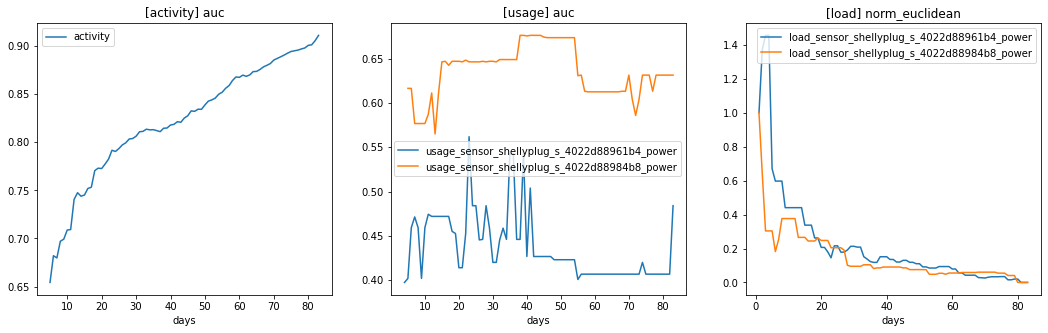

In [139]:
evaluation.visualize_cold_start(metrics)

In [140]:
tolerance = [0.05, 0.1, 0.15, 0.2, 0.25]

# updating the configuration
evaluation.config['evaluation'] = {}
evaluation.config['evaluation']['cold_start'] = {}
evaluation.config['evaluation']['cold_start']['metrics'] = metrics
evaluation.config['evaluation']['cold_start']['tolerance'] = tolerance

# calculatung the cold start days
evaluation.get_cold_start_days(tolerance_values=tolerance)
evaluation.cold_start_days

,activity,usage_sensor_shellyplug_s_4022d88961b4_power,usage_sensor_shellyplug_s_4022d88984b8_power,load_sensor_shellyplug_s_4022d88961b4_power,load_sensor_shellyplug_s_4022d88984b8_power,framework
tolerance,,,,,,
0.05,59.0,84.0,84.0,64.0,77.0,84.0
0.10,42.0,84.0,74.0,51.0,36.0,84.0
0.15,21.0,83.0,14.0,41.0,28.0,83.0
0.20,12.0,83.0,5.0,33.0,27.0,83.0
0.25,8.0,83.0,5.0,20.0,20.0,83.0


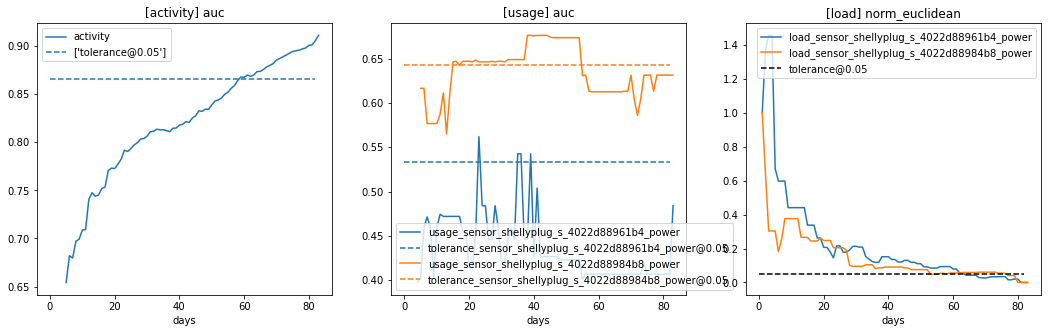

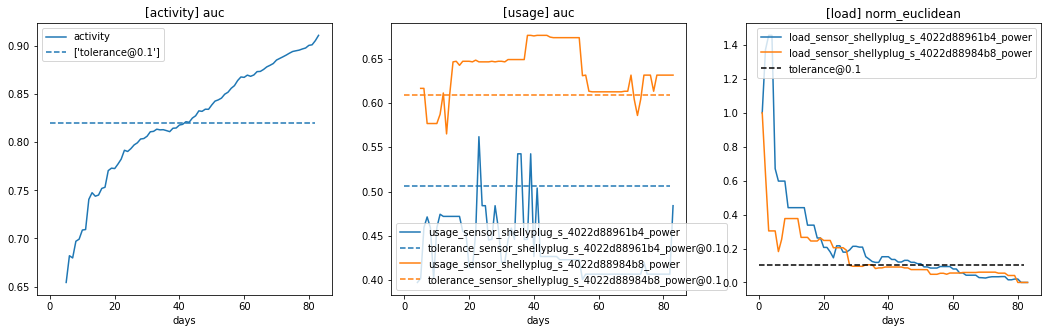

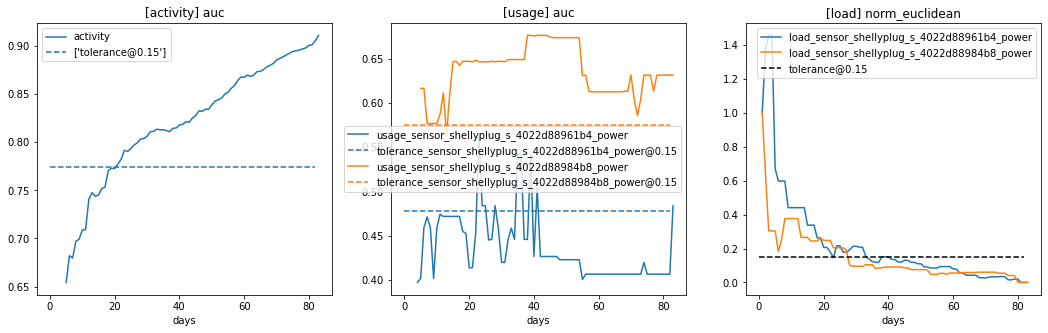

In [141]:
# visualizing different tolerance values
for tolerance in [0.05, 0.1, 0.15]:
    tolerance = {
        'activity': tolerance, 
        'usage': tolerance, 
        'load': tolerance
    }
    evaluation.visualize_cold_start(metrics, tolerance)

In [144]:
optimal_tolerance = [0.05]
# converting cold start scores to tabular format for comparisons with other households
cold_start_days = {}
cold_start_days[household_id] = evaluation.cold_start_to_summary(optimal_tolerance)

helper.concat_household_scores(cold_start_days).apply(lambda x: x.values[0])

activity usage     load     framework
device           -     0   1    0   1         -
household                                      
1               59    84  84   64  77        84

### 2.12 evaluation: calculate costs per device run

In [151]:
evaluation.price.get_history(evaluation.start, evaluation.end).index.values

array(['2022-12-24T23:00:00.000000000', '2022-12-25T00:00:00.000000000',
       '2022-12-25T01:00:00.000000000', ...,
       '2023-03-18T21:00:00.000000000', '2023-03-18T22:00:00.000000000',
       '2023-03-18T23:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
evaluation.

In [184]:
prices = evaluation.price.get_history(evaluation.start, evaluation.end).values
price_idx = evaluation.price.get_history(evaluation.start, evaluation.end).index.values

In [185]:
dt = np.datetime64(date) + np.timedelta64(int(hour), "h")

In [197]:
np.where(price_idx == dt)

(array([2011], dtype=int64),)

In [186]:
i = np.where(price_idx == dt)[0][0]
i = np.where(price_idx == dt)[0][0]

In [196]:
i

2011

In [190]:
load = evaluation.load.get_true_loads(evaluation.config['user_input']['shiftable_devices'])['sensor.shellyplug_s_4022d88961b4_power']
load

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
2022-12-25 18:00:00,0.248276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-12-26 15:00:00,0.328814,0.358647,0.346429,795.214932,541.985593,0.340136,0.3675,0.356716,0.373913,0.352,...,0.375,0.376471,0.373571,0.364474,319.984146,379.604,0,0,0,0
2022-12-29 07:00:00,736.494286,984.130769,318.092188,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-12-30 14:00:00,408.513615,45.988321,308.830833,1.119171,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-02 07:00:00,639.325,823.634615,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-08 16:00:00,871.181735,529.936458,0.313978,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-11 09:00:00,892.272678,615.633962,0.340127,0.352597,0.366929,0.365734,0.345238,0.376761,0.365806,0.37987,...,0,0,0,0,0,0,0,0,0,0
2023-01-13 15:00:00,827.925877,752.277692,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-15 15:00:00,866.359167,431.187692,0.333793,0.340845,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-16 18:00:00,1041.362112,542.847257,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
before = np.zeros(i)
before

array([0., 0., 0., ..., 0., 0., 0.])

In [198]:
date

numpy.datetime64('2023-03-18')

In [193]:
load.shape[0]

44

In [194]:
prices.shape[0]

2017

In [195]:
before.shape[0]

2011

In [200]:
after = np.zeros(prices.shape[0] - before.shape[0])
after

array([0., 0., 0., 0., 0., 0.])

In [204]:
before

array([0., 0., 0., ..., 0., 0., 0.])

In [205]:
load

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
2022-12-25 18:00:00,0.248276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-12-26 15:00:00,0.328814,0.358647,0.346429,795.214932,541.985593,0.340136,0.3675,0.356716,0.373913,0.352,...,0.375,0.376471,0.373571,0.364474,319.984146,379.604,0,0,0,0
2022-12-29 07:00:00,736.494286,984.130769,318.092188,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-12-30 14:00:00,408.513615,45.988321,308.830833,1.119171,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-02 07:00:00,639.325,823.634615,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-08 16:00:00,871.181735,529.936458,0.313978,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-11 09:00:00,892.272678,615.633962,0.340127,0.352597,0.366929,0.365734,0.345238,0.376761,0.365806,0.37987,...,0,0,0,0,0,0,0,0,0,0
2023-01-13 15:00:00,827.925877,752.277692,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-15 15:00:00,866.359167,431.187692,0.333793,0.340845,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-16 18:00:00,1041.362112,542.847257,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
load = np.hstack([before, load, after])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [201]:
def calculate_cost(self, date, hour, load):
    import numpy as np

    if np.isnan(hour):
        return np.nan
    else:
        
        prices = self.price.get_history(self.start, self.end).values

        dt = np.datetime64(date) + np.timedelta64(int(hour), "h")
        # getting the correct position for the load in the load array
        i = np.where(price_idx == dt)[0][0]
        i = np.where(price_idx == dt)[0][0]

        # reshaping the load array and calculating the costs
        before = np.zeros(i)
        after = np.zeros(prices.shape[0] - before.shape[0])
        load = np.hstack([before, load, after])
        return np.dot(load, prices)
    
# add to Evaluation agent
setattr(Evaluation_Agent, 'calculate_cost', calculate_cost)
del calculate_cost

In [202]:
evaluation.calculate_cost(date, hour, evaluation.load.get_true_loads(evaluation.config['user_input']['shiftable_devices'])['sensor.shellyplug_s_4022d88961b4_power'])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [153]:
def _get_usage(self, device, date):
    return self.df["usage"].loc[date, device + "_usage"]

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_usage', _get_usage)
del _get_usage

In [154]:
def _get_activity(self, date, hour):
    import numpy as np

    if np.isnan(hour):
        return np.nan
    else:
        dt = np.datetime64(date) + np.timedelta64(int(hour), "h")
        return self.activity.input.loc[dt, "activity"]
    
# add to Evaluation agent
setattr(Evaluation_Agent, '_get_activity', _get_activity)
del _get_activity

In [155]:
def _get_starting_times(self, device):
    import numpy as np

    # extracts hours in which the device is turned on,
    # conditional on that the device was turned off the hour before
    times = self.df["load"][device].index.to_numpy()
    hour = self.df["load"][device].values
    before = np.insert(hour, 0, 0)[:-1]
    return times[(before == 0) & (hour != 0)]

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_starting_times', _get_starting_times)
del _get_starting_times

In [156]:
def _get_starting_hours(self, device, date):
    import numpy as np
    import pandas as pd

    times = self._get_starting_times(device)
    date = np.datetime64(date) if type(date) != np.datetime64 else date
    times = times[(times >= date) & (times < date + np.timedelta64(1, "D"))]
    hours = (
        pd.Series(times).apply(lambda x: x.hour).to_numpy()
        if times.shape[0] != 0
        else np.nan
    )
    return hours

# add to Evaluation agent
setattr(Evaluation_Agent, '_get_starting_hours', _get_starting_hours)
del _get_starting_hours

In [157]:
def _get_load(self, true_loads, device, date, hour):
    import numpy as np

    try:
        dt = np.datetime64(date) + np.timedelta64(hour, "h")
    # if hour == NaN, return zero load profile
    except ValueError:
        return np.zeros(24)
    try:
        return true_loads[device].loc[dt].values
    except KeyError as ke:
        # return a zero load profile if the datetime index was not found
        if str(ke).split("(")[0] == "numpy.datetime64":
            return np.zeros(24)
        # in any other case raise the key error
        else:
            raise ke
            
# add to Evaluation agent
setattr(Evaluation_Agent, '_get_load', _get_load)
del _get_load

In [168]:
hour = 18

In [169]:
date 

numpy.datetime64('2023-03-18')

In [170]:
dt = np.datetime64(date) + np.timedelta64(hour, "h")

In [171]:
dt

numpy.datetime64('2023-03-18T18','h')

In [ ]:
true_loads[device].loc[dt].values

In [ ]:

import numpy as np

try:
    dt = np.datetime64(date) + np.timedelta64(hour, "h")
# if hour == NaN, return zero load profile
except ValueError:
    return np.zeros(24)
try:
    return true_loads[device].loc[dt].values
except KeyError as ke:
    # return a zero load profile if the datetime index was not found
    if str(ke).split("(")[0] == "numpy.datetime64":
        return np.zeros(24)
    # in any other case raise the key error
    else:
        raise ke

### 2.13 evaluation: performance metrics

In [158]:
def evaluate(self, activity_threshold, usage_threshold):
    name = f"activity: {activity_threshold}; usage: {usage_threshold}"
    self.pipeline('recommendation', activity_threshold=activity_threshold, usage_threshold=usage_threshold, dates='all')
    self.results[name] = self._evaluate()

# add to Evaluation agent
setattr(Evaluation_Agent, 'evaluate', evaluate)
del evaluate

In [159]:
def _evaluate(self):
    import numpy as np

    df = self.output["recommendation"].copy()

    # usage and activity target
    df["usage_true"] = df.apply(lambda row: self._get_usage(row["device"], row.name), axis=1)
    df["activity_true"] = df.apply(lambda row: self._get_activity(row.name, row["recommendation"]), axis=1)
    df["acceptable"] = df["usage_true"] * df["activity_true"]

    # starting times
    df["starting_times"] = df.apply(
        lambda row: self._get_starting_hours(row["device"], row.name), axis=1
    )
    df["relevant_start"] = abs(df["starting_times"] - df["recommendation"])
    df.loc[df["starting_times"].notna(), "relevant_start"] = df[
        df["starting_times"].notna()
    ].apply(
        lambda row: row["starting_times"][np.argmin(row["relevant_start"])], axis=1
    )

    # actual loads
    true_loads = self.load.get_true_loads(self.config["user_input"]["shiftable_devices"])
    df["load"] = df.apply(lambda row: self._get_load(true_loads, row["device"], row.name, row["relevant_start"]), axis=1)

    # calculating costs
    df["cost_no_recommendation"] = df.apply(lambda row: self.calculate_cost(row.name, row["relevant_start"], row["load"]), axis=1)
    df["cost_recommendation"] = df.apply(lambda row: self.calculate_cost(row.name, row["recommendation"], row["load"]),axis=1)
    df["savings"] = df["cost_no_recommendation"] - df["cost_recommendation"]
    df["relative_savings"] = df["savings"] / df["cost_no_recommendation"]

    return df[
        [
            "device",
            "recommendation",
            "acceptable",
            "relevant_start",
            "cost_no_recommendation",
            "cost_recommendation",
            "savings",
            "relative_savings",
        ]
    ]

# add to Evaluation agent
setattr(Evaluation_Agent, '_evaluate', _evaluate)
del _evaluate

In [160]:
def _result_to_summary(self, result):
    return {
        "n_recommendations": result["recommendation"].count(),
        "acceptable": result["acceptable"].mean(),
        "total_savings": (result["acceptable"] * result["savings"]).sum(),
        "relative_savings_mean": result["relative_savings"].mean(),
        "relative_savings_median": result["relative_savings"].median(),
    }

# add to Evaluation agent
setattr(Evaluation_Agent, '_result_to_summary', _result_to_summary)
del _result_to_summary

In [161]:
def results_to_summary(self):
    import pandas as pd

    summary = {
        name: self._result_to_summary(result)
        for name, result in self.results.items()
    }
    return pd.DataFrame.from_dict(summary, orient="index")

# add to Evaluation agent
setattr(Evaluation_Agent, 'results_to_summary', results_to_summary)
del results_to_summary

### 2.14 evaluation: grid search and sensitivity

In [162]:
def grid_search(self, activity_thresholds, usage_thresholds):
    import itertools
    from tqdm import tqdm

    # updating the config
    try:
        self.config['evaluation']
    except:
        self.config['evaluation'] = {}

    self.config['evaluation']['grid_search'] = {}
    self.config['evaluation']['grid_search']['activity_thresholds'] = list(activity_thresholds)
    self.config['evaluation']['grid_search']['usage_thresholds'] = list(usage_thresholds)

    # testing candidate thresholds
    iterator = itertools.product(activity_thresholds, usage_thresholds)
    for thresholds in tqdm(list(iterator)):
        self.evaluate(thresholds[0], thresholds[1])
        
# add to Evaluation agent
setattr(Evaluation_Agent, 'grid_search', grid_search)
del grid_search

In [163]:
def get_sensitivity(self, target):
    import pandas as pd

    df = self.results_to_summary()
    sensitivity = pd.DataFrame()
    for threshold_name in df.index:
        thresholds = threshold_name.split("; ")
        activity_threshold, usage_threshold = [th.split(": ")[1] for th in thresholds]
        sensitivity.loc[activity_threshold, usage_threshold] = df.loc[threshold_name, target]
    # sort and name rows and columns
    sensitivity = sensitivity.loc[sorted(sensitivity.index), :]
    sensitivity = sensitivity.loc[:, sorted(sensitivity.columns)]
    sensitivity.index.name = "activity_threshold"
    sensitivity.columns.name = "usage_threshold"
    return sensitivity

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_sensitivity', get_sensitivity)
del get_sensitivity

In [164]:
def get_optimal_thresholds(self):
    df = self.results_to_summary()
    result = df.sort_values(by='total_savings').iloc[-1, :]
    thresholds = result.name.split('; ')
    thresholds = [threshold.split(': ') for threshold in thresholds]
    thresholds = {f"{threshold}_threshold": value for threshold, value in thresholds}
    self.config['evaluation']['grid_search']['optimal_thresholds'] = thresholds
    return thresholds

# add to Evaluation agent
setattr(Evaluation_Agent, 'get_optimal_thresholds', get_optimal_thresholds)
del get_optimal_thresholds

In [165]:
def thresholds_to_index(self, activity_threshold='optimal', usage_threshold='optimal'):
    if activity_threshold == 'optimal':
        activity_threshold = self.config['evaluation']['grid_search']['optimal_thresholds']['activity_threshold']
    if usage_threshold == 'optimal':
        usage_threshold = self.config['evaluation']['grid_search']['optimal_thresholds']['usage_threshold']
    return f"activity: {activity_threshold}; usage: {usage_threshold}"

# add to Evaluation agent
setattr(Evaluation_Agent, 'thresholds_to_index', thresholds_to_index)
del thresholds_to_index

In [166]:
def optimal_result_to_summary(self):
    import pandas as pd
    optimal_thresholds = self.get_optimal_thresholds()
    optimal_thresholds_index = self.thresholds_to_index()
    result = self.results_to_summary().loc[optimal_thresholds_index, :]
    result = result.append(pd.Series(optimal_thresholds))
    result.name = self.config['data']['household']
    return result

# add to Evaluation agent
setattr(Evaluation_Agent, 'optimal_result_to_summary', optimal_result_to_summary)
del optimal_result_to_summary

In [ ]:
evaluation.calculate_cost(row.name, row["relevant_start"], row["load"])

In [167]:
evaluation.evaluate(0.5, 0.2)
list(evaluation.results.values())[0]

ValueError: negative dimensions are not allowed

In [ ]:
evaluation.results_to_summary().round(2)

In [ ]:
steps = 8
activity_thresholds = np.linspace(1/(steps), 1, steps)[:-1]
usage_thresholds = np.linspace(1/steps, 1, steps)[:-1]
print(f"[grid search] candidate thresholds {activity_thresholds}\n")
time.sleep(0.3)
evaluation.grid_search(activity_thresholds, usage_thresholds)

In [ ]:
evaluation.results_to_summary().round(2)

# 3. Complete Evaluation Agent

In [ ]:
# Original Evaluation Agent
# ===============================================================================================
class Evaluation_Agent:
    def __init__(self, DATA_PATH, model_type, config, load_data=True, load_files=None, weather_sel=False, xai = False):
        import agents
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()

        self.model_type = model_type
        self.config = config
        self.weather_sel = weather_sel
        self.xai = xai
        house_df = helper.load_household(DATA_PATH, config["data"]["household"], weather_sel = weather_sel)
        if load_data:
            self.preparation = agents.Preparation_Agent(house_df)
        else:
            self.preparation = agents.Preparation_Agent(None)

        self.price = (
            agents.Price_Agent(helper.create_day_ahead_prices_df(DATA_PATH, "Day-ahead Prices_201501010000-201601010000.csv"))
            if load_data
            else None
        )
        self.activity = None
        self.load = None
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_" + device.replace(" ", "_").replace("(", "").replace(")", "").lower())
            exec(f"self.{name} = None")
        self.recommendation = None
        self.df = {}
        self.output = {}
        self.errors = {}
        self.agent_scores = {}
        self.agent_predictions_list_activity = {}
        self.agent_predictions_list_usage = {}
        self.cold_start_scores = {}
        self.results = {}
        self.cold_start_days = pd.DataFrame()
        if load_files != None:
            self.load_from_drive(load_files)

    # helper: loading and storing intermediary results and further helper
    # -------------------------------------------------------------------------------------------
    def _load_object(self, filename):
        import pickle
        import json
        import yaml

        # using a command dict as a if-list
        commands = {
            "pkl": f"pickle.load(open('{filename}', 'rb'))",
            "json": f"json.load(open('{filename}', 'r'))",
            "yaml": f"yaml.load(open('{filename}', 'r'), Loader = yaml.Loader)",
        }

        *_, name, ftype = filename.split(".")
        name = name[name.rfind("_") + 1:]
        obj = eval(commands[ftype])
        self[name] = obj

    def load_from_drive(self, files):
        files = [files] if type(files) != list else files
        for filename in files:
            self._load_object(filename)

    def dump(self, EXPORT_PATH):
        import json
        import yaml
        import pickle

        # storing the current configuration
        json.dump(self.config, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                          + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_config.json", "w"), indent=4)

        # storing the prepared data
        if self.df != {}:
            pickle.dump(self.df, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                         + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_df.pkl", "wb"))

        # storing the agents' output
        if self.output != {}:
            pickle.dump(self.output, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                         + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_output.pkl", "wb"))

        # storing the results
        if self.results != {}:
            pickle.dump(self.results, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                        + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_results.pkl", "wb"))

        # storing the results
        if self.agent_scores != {}:
            pickle.dump(self.agent_scores, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                        + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_scores.pkl", "wb"))

        if self.agent_predictions_list_activity != {}:
            pickle.dump(self.agent_predictions_list_activity, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                         + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_predictions.pkl", "wb"))

        if self.agent_predictions_list_usage != {}:
            pickle.dump(self.agent_predictions_list_usage, open(EXPORT_PATH + str(self.config["data"]["household"]) + '_' + str(self.config["activity"]["model_type"]) +'_'
                                        + str(self.config["usage"]["model_type"]) + '_' + str(self.weather_sel) + "_predictions_usage.pkl", "wb"))

    def __getitem__(self, item):
        return eval(f"self.{item}")

    def __setitem__(self, key, value):
        exec(f"self.{key} = value")

    def _format_time(self, seconds):
        return "{:02.0f}".format(seconds // 60) + ":" + "{:02.0f}".format(seconds % 60)

    def _get_agent_names(self):
        devices = self.config["user_input"]["shiftable_devices"]
        names = ["activity", "load"] + ["usage_"+ str(device).replace(" ", "_").replace("(", "").replace(")", "").lower() for device in devices]
        return names

    # creating the default configuration
    # -------------------------------------------------------------------------------------------
    def get_default_config(self, agents):
        if type(agents) != list:
            agents = [agents]

        agents = [agent.lower() for agent in agents]
        for agent in agents:
            exec(f"self._get_default_{agent}_config()")

    def _get_default_preparation_config(self):
        from copy import deepcopy

        # preparation
        self.config["preparation"] = {}
        ## preparation: activity agent
        self.config["preparation"]["activity"] = {
            "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
            "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
            "aggregate": {"resample_param": "60T"},
            "activity": {
                "active_appliances": deepcopy(self.config["user_input"]["active_appliances"]),
                "threshold": deepcopy(self.config["user_input"]["threshold"]),
            },
            "time": {"features": ["hour", "day_name"]},
            "activity_lag": {"features": ["activity"], "lags": [24, 48, 72]},
        }
        # preparation: usage agent
        self.config["preparation"]["usage"] = {
            "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
            "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
            "activity": {
                "active_appliances": deepcopy(self.config["user_input"]["active_appliances"]),
                "threshold": deepcopy(self.config["user_input"]["threshold"]),
            },
            "aggregate_hour": {"resample_param": "60T"},
            "aggregate_day": {"resample_param": "24H"},
            "time": {"features": ["hour", "day_name"]},
            "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"]),
            "device": {"threshold": deepcopy(self.config["user_input"]["threshold"])},
        }
        # preparation: load agent
        self.config["preparation"]["load"] = {
            "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
            "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
            "aggregate": {"resample_param": "60T"},
            "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"]),
            "device": {"threshold": deepcopy(self.config["user_input"]["threshold"])},
        }

    def _get_default_activity_config(self):
        from copy import deepcopy

        if (self.activity == None):
            self.init_agents()
        self._get_dates()
        self.config["activity"] = {
            "model_type": self.model_type,
            "split_params": {
                "train_start": deepcopy(self.config["data"]["start_dates"]["activity"]),
                "test_delta": {"days": 1, "seconds": -1},
                "target": "activity",
            },
        }

    def _get_default_load_config(self):
        from copy import deepcopy

        if (self.load == None):
            self.init_agents()
        self._get_dates()
        self.config["load"] = {
            "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"])
        }

    def _get_default_usage_config(self):
        from copy import deepcopy

        if (self.activity == None) | (self.load == None):
            self.init_agents()
        self._get_dates()
        self.config["usage"] = {
            "model_type":  self.model_type,
            "train_start": deepcopy(self.config["data"]["start_dates"]["usage"]),
        }
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_" + device.replace(" ", "_").replace("(", "").replace(")", "").lower())
            self.config[name] = self.config["usage"]
            self.config["data"]["start_dates"][name] = self.config["data"]["start_dates"]["usage"]

    # extracting the available dates in the data
    def get_first_date(self, df):
        import pandas as pd

        first_data = df.index.to_series()[0]
        return (first_data + pd.Timedelta("1D")).replace(hour=0, minute=0, second=0)

    def get_last_date(self, df):
        import pandas as pd

        last_data = df.index.to_series()[-1]
        return (last_data - pd.Timedelta("1D")).replace(hour=23, minute=59, second=59)

    def get_min_start_date(self, df):
        df = df.dropna()
        return df.loc[df.index.hour == 0, :].index[0]

    def _get_dates(self):
        import numpy as np

        # first and last date in the data
        self.config["data"]["first_date"] = str(self.get_first_date(self.preparation.input))[:10]
        self.config["data"]["last_date"] = str(self.get_last_date(self.preparation.input))[:10]
        # start dates
        start_dates = {}
        for agent, data in self.df.items():
            start_dates[agent] = self.get_min_start_date(data)
        start_dates["combined"] = np.max(list(start_dates.values()))
        self.config["data"]["start_dates"] = {
            key: str(value)[:10] for key, value in start_dates.items()
        }


    # running the pipeline
    # -------------------------------------------------------------------------------------------
    def pipeline(self, agents, **kwargs):
        # converting single agent to list
        if type(agents) != list:
            agents = [agents]

        agents = [agent.lower() for agent in agents]

        if 'preparation' in agents:
            self._prepare(**kwargs)
        if 'activity' in agents:
            self._pipeline_activity_usage_load('activity', **kwargs)
        if 'usage' in agents:
            usage_agents = ["usage_"+ device.replace(" ", "_").replace("(", "").replace(")", "").lower() for device in self.config["user_input"]["shiftable_devices"]]
            for agent in usage_agents:
                self._pipeline_activity_usage_load(agent, **kwargs)
        if 'load' in agents:
            self._pipeline_activity_usage_load('load', **kwargs)
        if 'recommendation' in agents:
            self._get_recommendations(**kwargs)

    def init_agents(self):
        import agents

        # initialize the agents
        self.activity = agents.Activity_Agent(self.df["activity"])
        self.load = agents.Load_Agent(self.df["load"])

        # initialize usage agents for the shiftable devices: agent = usage_name
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_" + device.replace(" ", "_").replace("(", "").replace(")", "").lower())
            exec(f'self.{name} = agents.Usage_Agent(self.df["usage"], "{device}")')
            self.df[name] = self.df["usage"]

        self.recommendation = agents.Recommendation_Agent(
            self.df["activity"],
            self.df["usage"],
            self.df["load"],
            self.price.input,
            self.config["user_input"]["shiftable_devices"]
        )

    def _prepare(self, agent="all"):
        lines = {
            "activity": 'self.df["activity"] = self.preparation.pipeline_activity(self.preparation.input, self.config["preparation"]["activity"])',
            "usage": 'self.df["usage"] = self.preparation.pipeline_usage(self.preparation.input, self.config["preparation"]["usage"])',
            "load": 'self.df["load"] ,_,_ = self.preparation.pipeline_load(self.preparation.input, self.config["preparation"]["load"])',
        }
        if agent == "all":
            for agent in ["activity", "usage", "load"]:
                exec(lines[agent])
                print(f"[evaluation agent] Finished preparing the data for the {agent} agent.")
        else:
            exec(lines[agent])
            print(f"[evaluation agent] Finished preparing the data for the {agent} agent.")

    def _pipeline_activity_usage_load(self, agent, verbose=1):
        import pandas as pd
        from IPython.display import clear_output
        import time

        self.output[agent] = {}
        self.errors[agent] = {}

        # init agents
        if (self.activity == None) | (self.load == None):
            self.init_agents()

        # determining the dates
        dates = self.df[agent].index.to_series()
        start = pd.to_datetime(self.config["data"]["start_dates"][agent])
        end = pd.to_datetime(self.config["data"]["last_date"]).replace(
            hour=23, minute=59, second=59
        )
        dates = dates[(dates >= start) & (dates <= end)].resample("1D").count()
        dates = [str(date)[:10] for date in list(dates.index)]

        # pipeline funtion
        start = time.time() if verbose >= 1 else None
        for date in dates:
            try:
                self.output[agent][date] = eval(f'self.{agent}.pipeline(self.{agent}.input, "{date}", **self.config["{agent}"])')
                # verbose
                if verbose >= 1:
                    clear_output(wait=True)
                    elapsed = time.time() - start
                    remaining = (elapsed / (len(dates)) * (len(dates) - (dates.index(date) + 1)))
                    print(f"agent:\t\t{agent}")
                    print(f"progress: \t{dates.index(date)+1}/{len(dates)}")
                    print(f"time:\t\t[{self._format_time(elapsed)}<{self._format_time(remaining)}]\n")
                    print(self.output[agent][date])
            except Exception as e:
                self.errors[agent][date] = type(e).__name__

    def _get_recommendations(
        self, activity_threshold, usage_threshold, dates: tuple = "all"
    ):
        import numpy as np
        from IPython.display import clear_output

        # determining dates
        start = (
            self.config["data"]["start_dates"]["combined"]
            if dates == "all"
            else dates[0]
        )
        end = self.config["data"]["last_date"] if dates == "all" else dates[1]
        dates = np.arange(
            np.datetime64(start),
            np.datetime64(end) + np.timedelta64(1, "D"),
            np.timedelta64(1, "D"),
        )
        dates = [str(date) for date in dates]

        # creating recommendations
        self.errors["recommendation"] = {}
        self.output["recommendation"] = {}
        for date in dates:
            try:
                self.output["recommendation"][date] = self.recommendation.pipeline(
                    date, activity_threshold, usage_threshold, evaluation=self.output
                )
            except Exception as e:
                self.errors["recommendation"][date] = e

        # merging the recommendations into one dataframe
        df = list(self.output["recommendation"].values())[0]

        for idx in range(1, len(self.output["recommendation"].values())):
            df = df.append(list(self.output["recommendation"].values())[idx])
        df.set_index("recommendation_date", inplace=True)
        self.output["recommendation"] = df
        clear_output()

    # individual agent scores
    # -------------------------------------------------------------------------------------------
    def get_agent_scores(self, xai=False, **args):
        self.xai =xai
        scores = {}
        scores['activity_auc'] = None
        scores['time_mean_lime_activity'] = {}
        scores['time_mean_shap_activity'] = {}
        scores['usage_auc'] = {}
        scores['time_mean_lime_usage'] = {}
        scores['time_mean_shap_usage'] = {}
        scores['load_mse'] = {}

        agents = self._get_agent_names()
        for agent in agents:
            agent_type = agent.split('_')[0]

            if agent_type == 'activity':
                _, auc_test_activity, _, time_mean_lime_activity, time_mean_shap_activity, predictions_list_activity = self[agent].evaluate(self[agent].input, **self.config[agent], xai=self.xai, **args)
                scores['activity_auc'] = auc_test_activity
                scores['time_mean_lime_activity'] = time_mean_lime_activity
                scores['time_mean_shap_activity'] = time_mean_shap_activity

            if agent_type == 'usage':
                _, auc_test_usage, _, time_mean_lime_usage, time_mean_shap_usage, predictions_list_usage = self[agent].evaluate(self[agent].input, **self.config[agent], xai=self.xai, **args)
                scores['usage_auc'][self[agent].device] = auc_test_usage
                scores['time_mean_lime_usage'] = time_mean_lime_usage
                scores['time_mean_shap_usage'] = time_mean_shap_usage

            if agent_type == 'load':
                try:
                    scores['load_mse'] = self.load.evaluate(**self.config['load'], evaluation=self.output['load'])
                except KeyError:
                    scores['load_mse'] = self.load.evaluate(**self.config['load'])
        self.agent_scores = scores
        self.agent_predictions_list_activity = predictions_list_activity
        self.agent_predictions_list_usage = predictions_list_usage
        return scores, predictions_list_activity, predictions_list_usage

    def agent_scores_to_summary(self, scores='default'):
        import pandas as pd

        if scores == 'default':
            scores = self.agent_scores

        summary = {}
        summary['activity_auc'] = pd.DataFrame()
        summary['usage_auc'] = pd.DataFrame()
        summary['load_mse'] = pd.DataFrame()

        household_id = self.config['data']['household']
        devices = self.config['user_input']['shiftable_devices']

        # activity
        summary['activity_auc'].loc[household_id, '-'] = scores['activity_auc']
        # usage
        i = 0
        for device in devices:
            summary['usage_auc'].loc[household_id, i] = scores['usage_auc'][device]
            i += 1
        # load
        i = 0
        for device in devices:
            summary['load_mse'].loc[household_id, i] = scores['load_mse'][device]
            i += 1

        summary['activity_auc'].index.name = 'household'
        summary['usage_auc'].index.name = 'household'
        summary['load_mse'].index.name = 'household'
        summary['usage_auc'].columns.name = 'device'
        summary['load_mse'].columns.name = 'device'
        return summary

    def predictions_to_xai_metrics(self, predictions, activity_threshold= 0.5, usage_threshold= 0.5):
        import numpy as np
        import sklearn.metrics

        y_true = np.array(predictions[0])
        y_hat_test = np.array(predictions[1])
        y_hat_lime = np.array(predictions[2])
        y_hat_shap = np.array(predictions[3])

        self.activity_threshold = activity_threshold
        self.usage_threshold = usage_threshold

        self.y_true = y_true
        self.y_hat_test = y_hat_test
        self.y_hat_lime = y_hat_lime
        self.y_hat_shap = y_hat_shap

        #turn y_hat test into binary
        self.y_hat_test_bin = np.where(y_hat_test > activity_threshold, 1, 0)
        self.y_hat_lime_bin = np.where(y_hat_lime > activity_threshold, 1, 0)
        self.y_hat_shap_bin = np.where(y_hat_shap > activity_threshold, 1, 0)


        xai_scores = {}
        xai_scores['activity_lime_auc_true'] = None
        xai_scores['activity_shap_auc_true'] = {}
        xai_scores['activity_lime_auc_pred'] = {}
        xai_scores['activity_shap_auc_pred'] = {}
        xai_scores['activity_lime_MAE'] = {}
        xai_scores['activity_shap_MAE'] = {}

        # AUC of true - xai prediction
        xai_scores['activity_lime_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_lime)], y_hat_lime)
        xai_scores['activity_shap_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_shap)], y_hat_shap)

        # AUC of predicted probabilities - xai prediction
        xai_scores['activity_lime_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_lime)], self.y_hat_lime_bin)
        xai_scores['activity_shap_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_shap)], self.y_hat_shap_bin)

        # MAE
        MAE_SHAP = []
        zip_object = zip(self.y_hat_test[:len(y_hat_shap)],self.y_hat_shap)
        for list1_i, list2_i in zip_object:
            MAE_SHAP.append(abs(list1_i - list2_i))

        MAE_LIME = []
        zip_object = zip(self.y_hat_test[:len(y_hat_lime)], self.y_hat_lime)
        for list1_i, list2_i in zip_object:
            MAE_LIME.append(abs(list1_i - list2_i))

        xai_scores['activity_lime_MAE'] = np.mean(MAE_LIME)
        xai_scores['activity_shap_MAE'] = np.mean(MAE_SHAP)

        self.xai_scores = xai_scores
        return xai_scores

    def predictions_to_xai_metrics_usage(self, predictions, activity_threshold= 0.5, usage_threshold= 0.5):
        import numpy as np
        import sklearn.metrics

        y_true = np.array(predictions[0])
        y_hat_test = np.array(predictions[1])
        y_hat_lime = np.array(predictions[2])
        y_hat_shap = np.array(predictions[3])

        self.activity_threshold = activity_threshold
        self.usage_threshold = usage_threshold

        self.y_true = y_true
        self.y_hat_test = y_hat_test
        self.y_hat_lime = y_hat_lime
        self.y_hat_shap = y_hat_shap

        #turn y_hat test into binary
        self.y_hat_test_bin = np.where(y_hat_test > usage_threshold, 1, 0)
        self.y_hat_lime_bin = np.where(y_hat_lime > usage_threshold, 1, 0)
        self.y_hat_shap_bin = np.where(y_hat_shap > usage_threshold, 1, 0)


        xai_scores = {}
        xai_scores['usage_lime_auc_true'] = None
        xai_scores['usage_shap_auc_true'] = {}
        xai_scores['usage_lime_auc_pred'] = {}
        xai_scores['usage_shap_auc_pred'] = {}
        xai_scores['usage_lime_MAE'] = {}
        xai_scores['usage_shap_MAE'] = {}

        # AUC of true - xai prediction
        xai_scores['usage_lime_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_lime)], y_hat_lime)
        xai_scores['usage_shap_auc_true'] = sklearn.metrics.roc_auc_score(y_true[:len(y_hat_shap)], y_hat_shap)

        # AUC of predicted probabilities - xai prediction
        xai_scores['usage_lime_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_lime)], self.y_hat_lime_bin)
        xai_scores['usage_shap_auc_pred'] = sklearn.metrics.roc_auc_score(self.y_hat_test_bin[:len(y_hat_shap)], self.y_hat_shap_bin)

        # MAE

        MAE_SHAP = []
        zip_object = zip(self.y_hat_test[:len(y_hat_shap)], self.y_hat_shap)
        for list1_i, list2_i in zip_object:
            MAE_SHAP.append(abs(list1_i - list2_i))

        MAE_LIME = []
        zip_object = zip(self.y_hat_test[:len(y_hat_lime)], self.y_hat_lime)
        for list1_i, list2_i in zip_object:
            MAE_LIME.append(abs(list1_i - list2_i))

        xai_scores['usage_lime_MAE'] = np.mean(MAE_LIME)
        xai_scores['usage_shap_MAE'] = np.mean(MAE_SHAP)


        self.xai_scores = xai_scores
        return xai_scores

    # cold start: predict on all data
    # -------------------------------------------------------------------------------------------
    def predict_all(self, agent, **kwargs):
        agent_type = agent.split("_")[0]
        return eval(f"self._predict_all_{agent_type}(agent, **kwargs)")

    def _predict_all_load(self, agent, device):
        y_hat = {
            date: profiles.loc[device, :]
            for date, profiles in self.output[agent].items()
        }
        return y_hat

    def _predict_all_activity(self, agent):
        return self._predict_all_activity_usage(agent)

    def _predict_all_usage(self, agent):
        return self._predict_all_activity_usage(agent)

    def _predict_all_activity_usage(self, agent):
        import pandas as pd
        import numpy as np

        y_hat = {}
        # intitializing the error dict
        try:
            self.errors["evaluation"]
        except KeyError:
            self.errors["evaluation"] = {}

        try:
            self.errors["evaluation"][agent]
        except KeyError:
            self.errors["evaluation"][agent] = {}

        # determining the dates
        dates = np.arange(
            np.datetime64(self.config["data"]["start_dates"][agent]),
            np.datetime64(self.config["data"]["last_date"]) + np.timedelta64(1, "D"),
            np.timedelta64(1, "D"),
        )
        start = dates[0]
        end = dates[-1] + pd.Timedelta(days=1, seconds=-1)

        # creating X_test
        X_test, _, _, _ = self[agent].train_test_split(
            self[agent].input,
            dates[-1] + np.timedelta64(1, "D"),
            train_start=self.config["data"]["start_dates"][agent],
        )

        # creating predictions
        for date in dates:
            X_train, y_train, _, _ = self[agent].train_test_split(
                self[agent].input,
                date,
                train_start=self.config["data"]["start_dates"][agent],
            )
            try:
                model = self[agent].fit(X_train, y_train, self.model_type)
                y_hat[date] = self[agent].predict(model, X_test)
            except Exception as e:
                self.errors["evaluation"][agent][date] = type(e).__name__
        return y_hat

    # cold start: calculate cold start scores
    # -------------------------------------------------------------------------------------------
    def get_cold_start_scores(self, fn: dict = "default"):
        from IPython.display import clear_output

        scores = {}
        fn = {} if fn == "default" else fn

        # activity-agent
        scores["activity"] = self._get_cold_start_score("activity", fn=fn.get("activity", "default"))
        clear_output()

        for device in self.config["user_input"]["shiftable_devices"]:
            name = device.replace(" ", "_").replace("(", "").replace(")", "").lower()
            # usage agent
            scores["usage_" + name] = self._get_cold_start_score("usage_" + name, fn=fn.get("usage", "default"))
            # load agent
            scores["load_" + name] = self._get_cold_start_score("load", fn=fn.get("load", "default"), device=device)
            clear_output()
        self.cold_start_scores = scores

    def _get_cold_start_score(self, agent, fn="default", **kwargs):
        import sklearn.metrics
        import numpy as np

        agent_type = agent.split("_")[0]
        # specifying the correct score function
        fn_dict = {
            "activity": f"self.{agent}.auc",
            "usage": f"self.{agent}.auc",
            "load": "sklearn.metrics.mean_squared_error",
        }
        fn = eval(fn_dict[agent_type]) if fn == "default" else fn

        # specifying the correct y_true, y_hat
        y_dict = {
            "activity": "self[agent].train_test_split(self[agent].input, date=np.datetime64(self.config['data']['last_date'])+np.timedelta64(1, 'D'), train_start=self.config['data']['start_dates'][agent])",
            "usage": "self[agent].train_test_split(self[agent].input, date=np.datetime64(self.config['data']['last_date'])+np.timedelta64(1, 'D'), train_start=self.config['data']['start_dates'][agent])",
            "load": "list(self.output['load'].values())[-1].loc[kwargs['device'], :]",
        }
        y_true = eval(y_dict[agent_type])
        y_true = y_true if agent_type == "load" else y_true[1]
        y_hat = self.predict_all(agent, **kwargs)

        # calculating the scores
        scores = {}
        for date, pred in y_hat.items():
            scores[date] = fn(y_true, pred)
        return scores

    def cold_start_scores_to_df(self):
        import pandas as pd
        import numpy as np

        scores_df = pd.DataFrame()
        # convert dicts into dataframe
        for key in self.cold_start_scores.keys():
            for date, score in self.cold_start_scores[key].items():
                scores_df.loc[str(date), key] = score

        # sort the dataframe
        cols = (
            ["activity"]
            + [col for col in scores_df if col.startswith("usage")]
            + [col for col in scores_df if col.startswith("load")]
        )
        scores_df.index = scores_df.index.map(np.datetime64)
        scores_df = scores_df[cols].sort_index()
        return scores_df

    def get_cold_start_days(self, tolerance_values):
        import pandas as pd

        self.cold_start_days = pd.DataFrame({"tolerance": []}).set_index("tolerance")
        scores_df = self.cold_start_scores_to_df()
        tolerance_fn = {
            "activity": "scores_df[agent].max() * (1 - tolerance[agent_type])",
            "usage": "scores_df[agent].max() * (1 - tolerance[agent_type])",
            "load": "tolerance['load']",
        }

        # agent coldstart days
        for tolerance in tolerance_values:
            tolerance = {"activity": tolerance, "usage": tolerance, "load": tolerance}

            for agent in scores_df.columns:
                agent_type = agent.split("_")[0]

                done = False
                day = 0
                while not done:
                    day += 1
                    tolerance_value = eval(tolerance_fn[agent_type])
                    if agent_type == "load":
                        done = all(scores_df[agent].values[day - 1:] < tolerance_value)
                    else:
                        done = all(scores_df[agent].values[day - 1:] > tolerance_value)
                self.cold_start_days.loc[tolerance[agent_type], agent] = day
        # framework cold start days
        self.cold_start_days['framework'] = self.cold_start_days.max(axis=1)

    def cold_start_to_summary(self, tolerance_values='all'):
        import pandas as pd

        if tolerance_values == 'all':
            tolerance_values = list(self.cold_start_days.index)

        household_id = self.config['data']['household']
        devices = self.config['user_input']['shiftable_devices']

        summary = {}
        summary['activity'] = {}
        summary['usage'] = {}
        summary['load'] = {}
        summary['framework'] = {}

        # activity agent
        summary['activity']['-'] = {}  # '-': placeholder for device
        summary['activity']['-'][household_id] = self.cold_start_days['activity'][tolerance_values].astype(int).to_list()
        # usage agent
        i = 0
        for device in devices:
            name = 'usage_' + device.replace(" ", "_").replace("(", "").replace(")", "").lower()
            summary['usage'][i] = {}
            summary['usage'][i][household_id] = self.cold_start_days[name][tolerance_values].astype(int).to_list()
            i += 1

        # load agent
        i = 0
        for device in devices:
            name = 'load_' + device.replace(" ", "_").replace("(", "").replace(")", "").lower()
            summary['load'][i] = {}
            summary['load'][i][household_id] = self.cold_start_days[name][tolerance_values].astype(int).to_list()
            i += 1

        # framework
        summary['framework']['-'] = {}  # '-': placeholder for device
        summary['framework']['-'][household_id] = self.cold_start_days['framework'][tolerance_values].astype(int).to_list()

        # converting the format
        for key, value in summary.items():
            summary[key] = pd.DataFrame(value)
            summary[key].columns.name = 'device'
            summary[key].index.name = 'household'
        return summary

    # cold start: visualizations
    # -------------------------------------------------------------------------------------------
    def _plot_axs(self, axs, y, x=None, legend=None, **kwargs):
        axs.plot(x, y) if x != None else axs.plot(y)
        axs.set(**kwargs)
        axs.legend(legend) if legend != None else None

    def visualize_cold_start(self, metrics_name: dict, tolerance: dict = None, figsize=(18, 5)):
        import matplotlib.pyplot as plt

        scores_df = self.cold_start_scores_to_df()
        fig, axs = plt.subplots(1, 3, figsize=figsize)

        # activity
        self._plot_axs(
            axs[0],
            x=range(1, scores_df.shape[0] + 1),
            y=scores_df["activity"],
            title=f"[activity] {metrics_name['activity']}",
        )
        legend = ['activity']
        if tolerance != None:
            tolerance_value = scores_df["activity"].max() * (1 - tolerance["activity"])
            color = axs[0].lines[-1].get_color()
            axs[0].plot([tolerance_value] * scores_df.shape[0], "--", c=color)
            legend.append([f"tolerance@{tolerance['activity']}"])
        axs[0].legend(legend)
        axs[0].set_xlabel("days")

        # usage
        usage_agents = [agent for agent in scores_df.columns if agent.find("usage") != -1]
        legend = []
        for agent in usage_agents:
            self._plot_axs(axs[1],
                x=range(1, scores_df.shape[0] + 1),
                y=scores_df[agent],
                title=f"[usage] {metrics_name['usage']}",
            )
            legend += [agent]
            if tolerance != None:
                tolerance_value = scores_df[agent].max() * (1 - tolerance["usage"])
                color = axs[1].lines[-1].get_color()
                axs[1].plot([tolerance_value] * scores_df.shape[0], "--", c=color)
                legend += [f"tolerance_{agent.replace('usage_', '')}@{tolerance['usage']}"]
        axs[1].legend(legend)
        axs[1].set_xlabel("days")

        # load
        load_agents = [agent for agent in scores_df.columns if agent.find("load") != -1]
        legend = []
        for agent in load_agents:
            self._plot_axs(
                axs[2],
                x=range(1, scores_df.shape[0] + 1),
                y=scores_df[agent],
                title=f"[load] {metrics_name['load']}",
            )
            legend += [agent]
        if tolerance != None:
            axs[2].plot([tolerance["load"]] * scores_df.shape[0], "--", c="black")
            legend += [f"tolerance@{tolerance['load']}"]
        axs[2].legend(legend)
        axs[2].set_xlabel("days")

    # evaluation: calculate costs per device run
    # -------------------------------------------------------------------------------------------
    def calculate_cost(self, date, hour, load):
        import numpy as np

        if np.isnan(hour):
            return np.nan
        else:
            price_idx = self.price.input.index.values
            prices = self.price.input.values

            dt = np.datetime64(date) + np.timedelta64(int(hour), "h")
            # getting the correct position for the load in the load array
            i = np.where(price_idx == dt)[0][0]
            i = np.where(price_idx == dt)[0][0]

            # reshaping the load array and calculating the costs
            before = np.zeros(i)
            after = np.zeros(prices.shape[0] - load.shape[0] - before.shape[0])
            load = np.hstack([before, load, after])
            return np.dot(load, prices)

    def _get_usage(self, device, date):
        return self.df["usage"].loc[date, device + "_usage"]

    def _get_activity(self, date, hour):
        import numpy as np

        if np.isnan(hour):
            return np.nan
        else:
            dt = np.datetime64(date) + np.timedelta64(int(hour), "h")
            return self.activity.input.loc[dt, "activity"]

    def _get_starting_times(self, device):
        import numpy as np

        # extracts hours in which the device is turned on,
        # conditional on that the device was turned off the hour before
        times = self.df["load"][device].index.to_numpy()
        hour = self.df["load"][device].values
        before = np.insert(hour, 0, 0)[:-1]
        return times[(before == 0) & (hour != 0)]

    def _get_starting_hours(self, device, date):
        import numpy as np
        import pandas as pd

        times = self._get_starting_times(device)
        date = np.datetime64(date) if type(date) != np.datetime64 else date
        times = times[(times >= date) & (times < date + np.timedelta64(1, "D"))]
        hours = (
            pd.Series(times).apply(lambda x: x.hour).to_numpy()
            if times.shape[0] != 0
            else np.nan
        )
        return hours

    def _get_load(self, true_loads, device, date, hour):
        import numpy as np

        try:
            dt = np.datetime64(date) + np.timedelta64(hour, "h")
        # if hour == NaN, return zero load profile
        except ValueError:
            return np.zeros(24)
        try:
            return true_loads[device].loc[dt].values
        except KeyError as ke:
            # return a zero load profile if the datetime index was not found
            if str(ke).split("(")[0] == "numpy.datetime64":
                return np.zeros(24)
            # in any other case raise the key error
            else:
                raise ke

    # evaluation: performance metrics
    # -------------------------------------------------------------------------------------------
    def evaluate(self, activity_threshold, usage_threshold):
        name = f"activity: {activity_threshold}; usage: {usage_threshold}"
        self.pipeline('recommendation', activity_threshold=activity_threshold, usage_threshold=usage_threshold, dates='all')
        self.results[name] = self._evaluate()

    def _evaluate(self):
        import numpy as np

        df = self.output["recommendation"].copy()

        # usage and activity target
        df["usage_true"] = df.apply(lambda row: self._get_usage(row["device"], row.name), axis=1)
        df["activity_true"] = df.apply(lambda row: self._get_activity(row.name, row["recommendation"]), axis=1)
        df["acceptable"] = df["usage_true"] * df["activity_true"]

        # starting times
        df["starting_times"] = df.apply(
            lambda row: self._get_starting_hours(row["device"], row.name), axis=1
        )
        df["relevant_start"] = abs(df["starting_times"] - df["recommendation"])
        df.loc[df["starting_times"].notna(), "relevant_start"] = df[
            df["starting_times"].notna()
        ].apply(
            lambda row: row["starting_times"][np.argmin(row["relevant_start"])], axis=1
        )

        # actual loads
        true_loads = self.load.get_true_loads(self.config["user_input"]["shiftable_devices"])
        df["load"] = df.apply(lambda row: self._get_load(true_loads, row["device"], row.name, row["relevant_start"]), axis=1)

        # calculating costs
        df["cost_no_recommendation"] = df.apply(lambda row: self.calculate_cost(row.name, row["relevant_start"], row["load"]), axis=1)
        df["cost_recommendation"] = df.apply(lambda row: self.calculate_cost(row.name, row["recommendation"], row["load"]),axis=1)
        df["savings"] = df["cost_no_recommendation"] - df["cost_recommendation"]
        df["relative_savings"] = df["savings"] / df["cost_no_recommendation"]

        return df[
            [
                "device",
                "recommendation",
                "acceptable",
                "relevant_start",
                "cost_no_recommendation",
                "cost_recommendation",
                "savings",
                "relative_savings",
            ]
        ]

    def _result_to_summary(self, result):
        return {
            "n_recommendations": result["recommendation"].count(),
            "acceptable": result["acceptable"].mean(),
            "total_savings": (result["acceptable"] * result["savings"]).sum(),
            "relative_savings_mean": result["relative_savings"].mean(),
            "relative_savings_median": result["relative_savings"].median(),
        }

    def results_to_summary(self):
        import pandas as pd

        summary = {
            name: self._result_to_summary(result)
            for name, result in self.results.items()
        }
        return pd.DataFrame.from_dict(summary, orient="index")

    # evaluation: grid search and sensitivity
    # -------------------------------------------------------------------------------------------
    def grid_search(self, activity_thresholds, usage_thresholds):
        import itertools
        from tqdm import tqdm

        # updating the config
        try:
            self.config['evaluation']
        except:
            self.config['evaluation'] = {}

        self.config['evaluation']['grid_search'] = {}
        self.config['evaluation']['grid_search']['activity_thresholds'] = list(activity_thresholds)
        self.config['evaluation']['grid_search']['usage_thresholds'] = list(usage_thresholds)

        # testing candidate thresholds
        iterator = itertools.product(activity_thresholds, usage_thresholds)
        for thresholds in tqdm(list(iterator)):
            self.evaluate(thresholds[0], thresholds[1])

    def get_sensitivity(self, target):
        import pandas as pd

        df = self.results_to_summary()
        sensitivity = pd.DataFrame()
        for threshold_name in df.index:
            thresholds = threshold_name.split("; ")
            activity_threshold, usage_threshold = [th.split(": ")[1] for th in thresholds]
            sensitivity.loc[activity_threshold, usage_threshold] = df.loc[threshold_name, target]
        # sort and name rows and columns
        sensitivity = sensitivity.loc[sorted(sensitivity.index), :]
        sensitivity = sensitivity.loc[:, sorted(sensitivity.columns)]
        sensitivity.index.name = "activity_threshold"
        sensitivity.columns.name = "usage_threshold"
        return sensitivity

    def get_optimal_thresholds(self):
        df = self.results_to_summary()
        result = df.sort_values(by='total_savings').iloc[-1, :]
        thresholds = result.name.split('; ')
        thresholds = [threshold.split(': ') for threshold in thresholds]
        thresholds = {f"{threshold}_threshold": value for threshold, value in thresholds}
        self.config['evaluation']['grid_search']['optimal_thresholds'] = thresholds
        return thresholds

    def thresholds_to_index(self, activity_threshold='optimal', usage_threshold='optimal'):
        if activity_threshold == 'optimal':
            activity_threshold = self.config['evaluation']['grid_search']['optimal_thresholds']['activity_threshold']
        if usage_threshold == 'optimal':
            usage_threshold = self.config['evaluation']['grid_search']['optimal_thresholds']['usage_threshold']
        return f"activity: {activity_threshold}; usage: {usage_threshold}"

    def optimal_result_to_summary(self):
        import pandas as pd
        optimal_thresholds = self.get_optimal_thresholds()
        optimal_thresholds_index = self.thresholds_to_index()
        result = self.results_to_summary().loc[optimal_thresholds_index, :]
        result = result.append(pd.Series(optimal_thresholds))
        result.name = self.config['data']['household']
        return result
